In [35]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

from tqdm.auto import tqdm
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as spl
import statsmodels.graphics.gofplots as gpl

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

from arch import arch_model 

import matplotlib.pyplot as plt

In [36]:
# JPY = yf.download('JPYRUB=X', start = '2017-01-01', end  = '2020-01-01')
# EUR = yf.download('EURRUB=X', start = '2017-01-01', end  = '2020-01-01')
# GBP = yf.download('GBPRUB=X', start = '2017-01-01', end  = '2020-01-01')

# 1. Загрузка данных

In [37]:
bonds_file_names = ['/SU26205RMFS3_rates.csv', 
                 '/SU26209RMFS5_rates.csv',
                 '/SU26212RMFS9_rates.csv',
                 '/SU26215RMFS2_rates.csv', 
                 '/SU26217RMFS8_rates.csv']

bonds_names = [x[1:len('SU26209RMFS5')+1] for x in bonds_file_names]

shares_file_names = ["/SBER.ME.csv", 
                  '/GAZP.ME.csv', 
                  '/YNDX.ME.csv',
                  '/MGNT.ME.csv', 
                  '/GMKN.ME.csv',
                  '/MTSS.ME.csv', 
                  '/PIKK.ME.csv', 
                  '/AFLT.ME.csv', 
                  '/POLY.ME.csv', 
                  '/RSTI.ME.csv']

shares_names = [x[1:5] for x in shares_file_names]

currencies_file_names = ['/D_USD.csv',
                      '/D_CNY.csv']

currencies_names = [x[3:6] for x in currencies_file_names]

risks_file_names = ['/IMOEX.ME.csv',
                    '/BZ=F.csv',
                    '/RTS.csv',
                   '/D_JPY.csv',
                    '/D_EUR.csv',
                    '/D_GBP.csv']   

risks_names = [x.split('/')[1].split('.csv')[0] for x in risks_file_names]

bonds_folder = 'bonds'
shares_folder = 'shares'
currencies_folder = 'currencies'
risks_folder = 'risk_factors'

bonds = [bonds_folder + x for x in bonds_file_names]
shares = [shares_folder + x for x in shares_file_names]
currencies = [currencies_folder + x for x in currencies_file_names]
risks = [risks_folder + x for x in risks_file_names]
zero_bonds = risks_folder + '/zero_bonds.csv'
metals = risks_folder + '/refined_precious_metals.xlsx'

In [41]:
def load_df(bonds=bonds, bonds_names=bonds_names, 
            shares=shares, shares_names=shares_names,
            currencies=currencies, currencies_names=currencies_names,
            risks=risks, risks_names=risks_names,
            zero_bonds=zero_bonds, metals=metals):
#     Основной df
    main_df = pd.read_csv(bonds[0], index_col='<DATE>')
    main_df.index = pd.to_datetime(main_df.index, format='%Y%m%d')
    main_df = main_df[[]]
    main_df.index.names = ['Date']
#     Загрузка облигаций
    for i in range(len(bonds)):
        df = pd.read_csv(bonds[i], index_col='<DATE>')
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
        df = df[['<CLOSE>']].rename(columns={'<CLOSE>': bonds_names[i]})
        df.index.names = ['Date']
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка акций
    for i in range(len(shares)):
        df = pd.read_csv(shares[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': shares_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка валют
    for i in range(len(currencies)):
        df = pd.read_csv(currencies[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': currencies_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка рисков
    for i in range(len(risks)):
        df = pd.read_csv(risks[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': risks_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка металлов
    df = pd.read_excel(metals, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Загрузка zero_bonds
    df = pd.read_csv(zero_bonds, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Заполнение пропусков
    main_df.fillna(method='ffill', inplace=True)
    main_df.fillna(method='backfill', inplace=True)

    return main_df

In [42]:
prices = load_df()

bonds = prices.iloc[:, 0:5]
shares = prices.iloc[:, 5:15]
currencies = prices.iloc[:, 15:17]
risk_factors = prices.iloc[:, 17:]

# 2. Описательная статистика риск-факторов

In [45]:
def plot_cor_matrix(risk_factors: pd.DataFrame) -> None:
    corr_matrix = risk_factors.corr()
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot()
    
    sns.heatmap(corr_matrix, annot=True)
    
    plt.show()

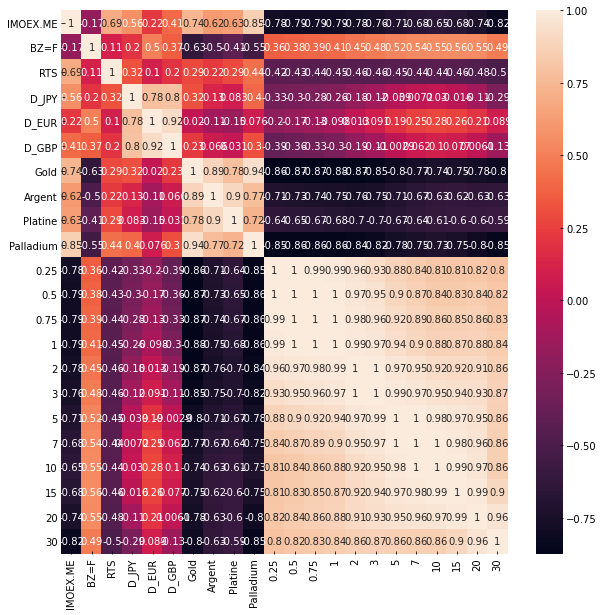

In [46]:
plot_cor_matrix(risk_factors)

In [30]:
def risk_factor_describe(risk_factor: pd.Series) -> None:
    risk_factor_name = risk_factor.name
    print(f"{'=' * 10} {risk_factor_name.upper()} {'=' * 10}")
    print(f"mean: {np.round(np.mean(risk_factor), 2)}")
    print(f"std: {np.round(np.std(risk_factor), 2)}")
    print(f"min: {np.round(np.min(risk_factor), 2)}")
    print(f"max: {np.round(np.max(risk_factor), 2)}")
    adfuller_pv = adfuller(risk_factor)[1]
    print(
        f"The Augmented Dickey-Fuller test, p-value: {adfuller_pv}, "
        f"series is {'non ' if adfuller_pv >= 0.05 else ''}stationary"
    )
    risk_factor_change = risk_factor.pct_change().iloc[1:]
    adfuller_pv = adfuller(risk_factor_change)[1]
    print(
        f"The Augmented Dickey-Fuller test for pct change, p-value: {adfuller_pv}, "
        f"series is {'non ' if adfuller_pv >= 0.05 else ''}stationary"
    )
    
    fig = plt.figure(figsize=(15, 15))
    
    ax = plt.subplot(511)
    sns.lineplot(x=risk_factor.index, y=risk_factor, ax=ax)
    plt.title('Price')
    
    ax = plt.subplot(512)
    sns.lineplot(x=risk_factor_change.index, y=risk_factor_change, ax=ax)
    plt.title('Price percent change')
    
    ax = plt.subplot(525)
    spl.plot_acf(risk_factor_change, lags=20, ax=ax)
    
    ax = plt.subplot(526)
    spl.plot_pacf(risk_factor_change, lags=20, ax=ax)
    
    ax = plt.subplot(527)
    normal_dist = gpl.ProbPlot(risk_factor_change, fit=True)
    normal_dist.qqplot(line='r', ax=ax)
    plt.title('Q-Q')
    
    ax = plt.subplot(528)
    normal_dist.ppplot(line='45', ax=ax)
    plt.title('P-P')
    
    ax = plt.subplot(529)
    normal_dist.probplot(line='r', ax=ax)
    plt.title('Prob')
    
    ax = plt.subplot(5, 2, 10)
    sns.distplot(risk_factor_change, ax=ax)
    plt.title('Distribution')
    
    plt.tight_layout()
    plt.show()

========== IMOEX.ME ==========
mean: 2478.9
std: 360.04
min: 1817.82
max: 3289.02
The Augmented Dickey-Fuller test, p-value: 0.8341597619769606, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.3281846425403031e-25, series is stationary


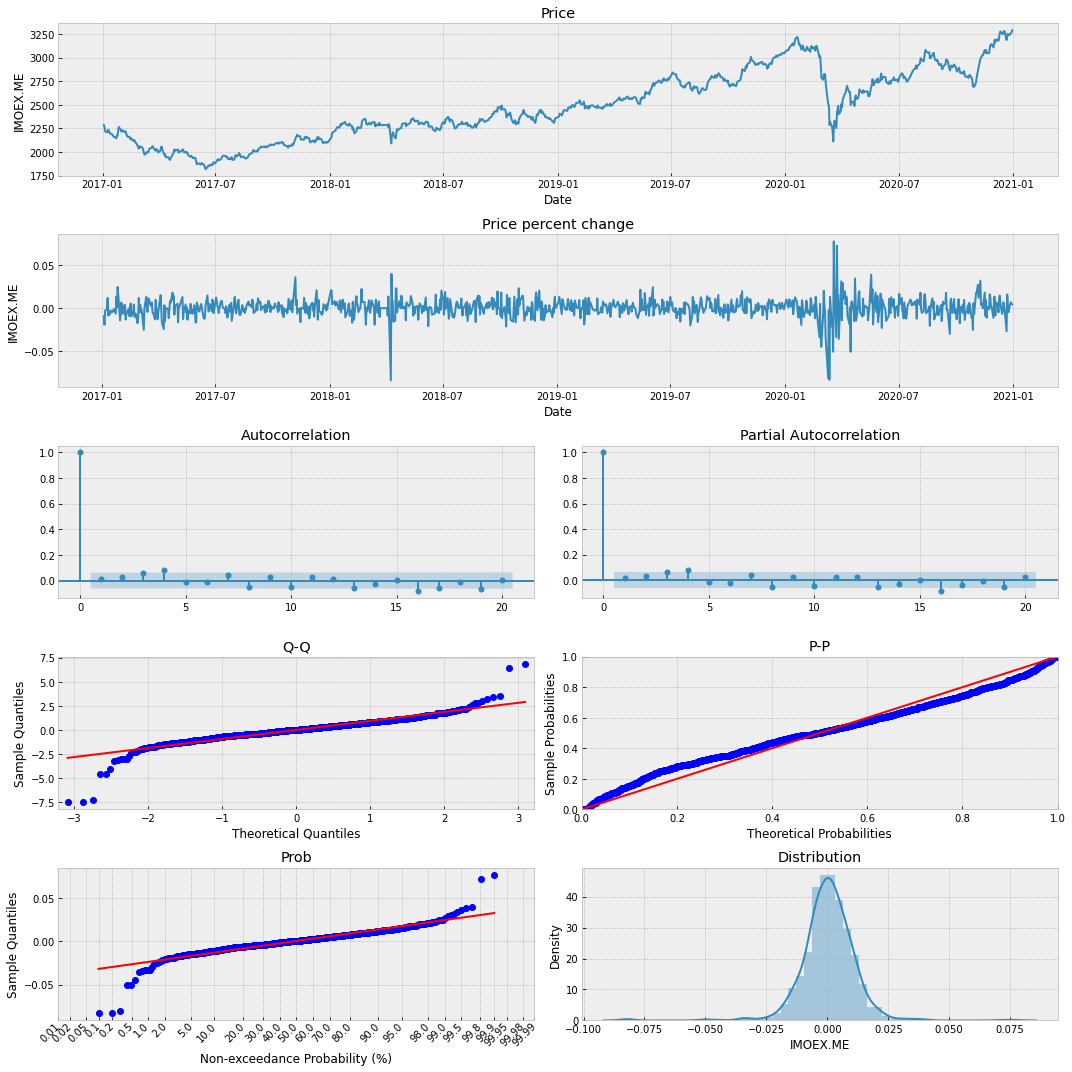

========== BZ=F ==========
mean: 58.54
std: 12.76
min: 19.33
max: 86.29
The Augmented Dickey-Fuller test, p-value: 0.29558777916016676, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.646745792770896e-07, series is stationary


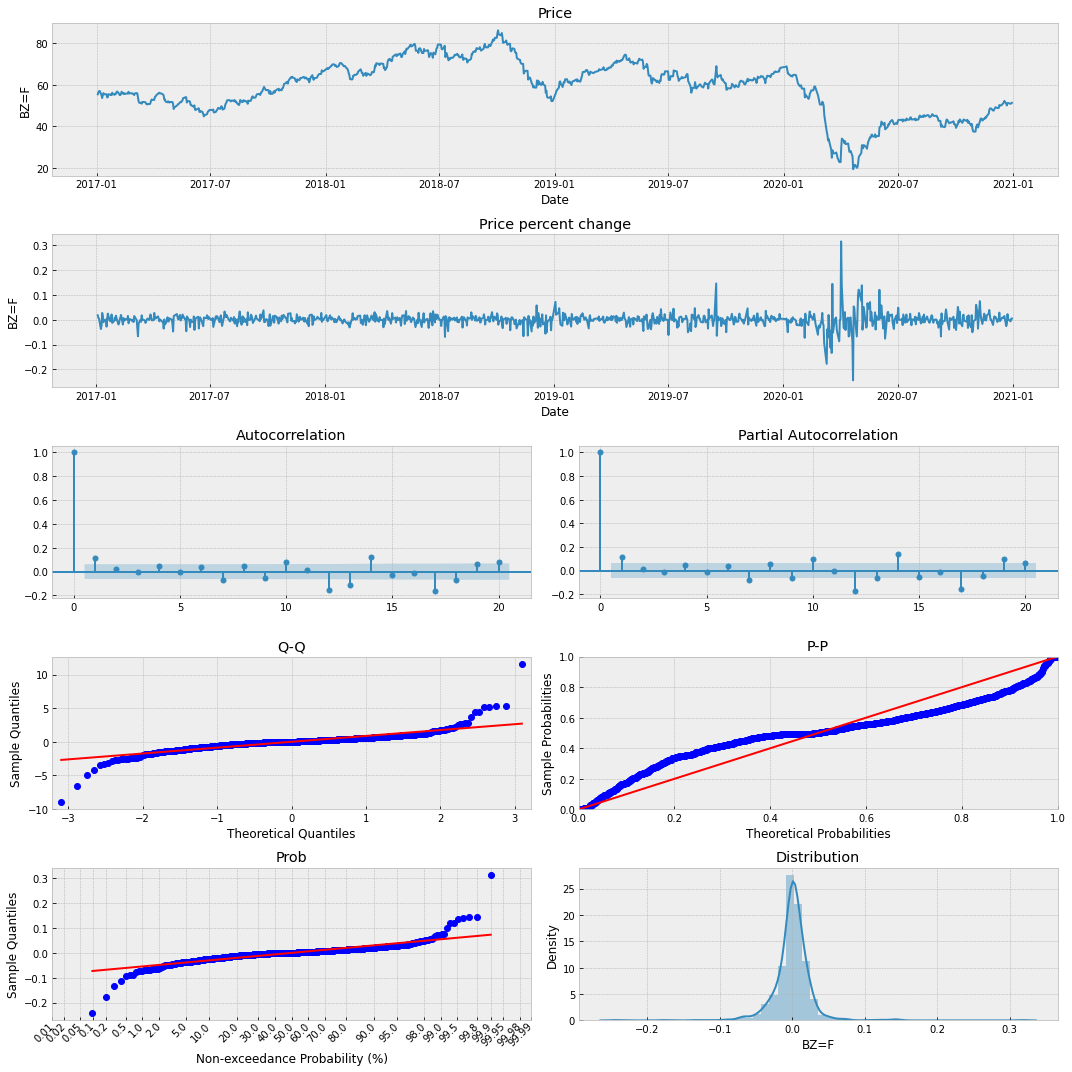

========== RTS ==========
mean: 1208.12
std: 133.8
min: 832.26
max: 1646.6
The Augmented Dickey-Fuller test, p-value: 0.2724882464435697, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.1400213521707747e-17, series is stationary


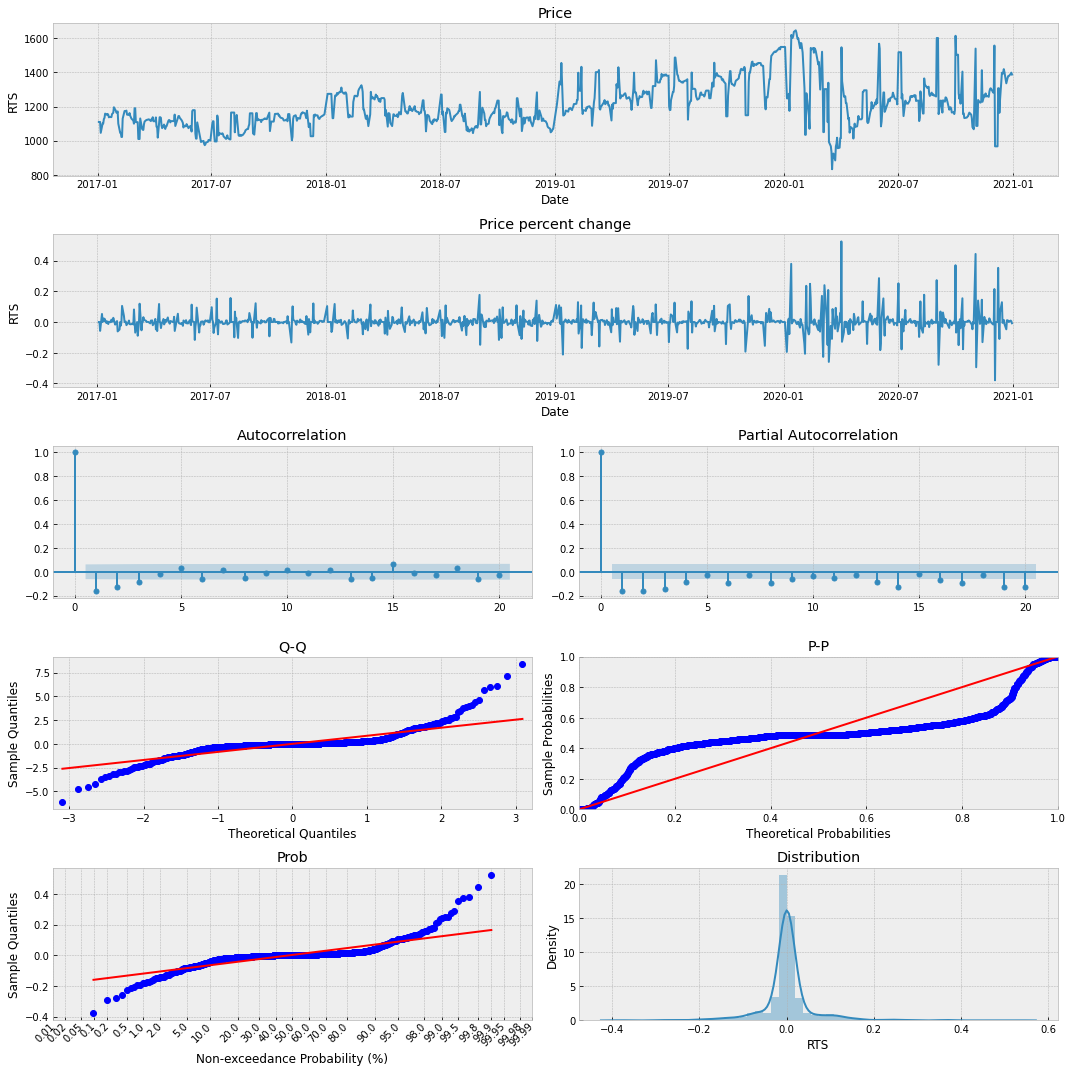

========== GOLD ==========
mean: 2983.32
std: 746.72
min: 2232.16
max: 4887.7
The Augmented Dickey-Fuller test, p-value: 0.970707983245699, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


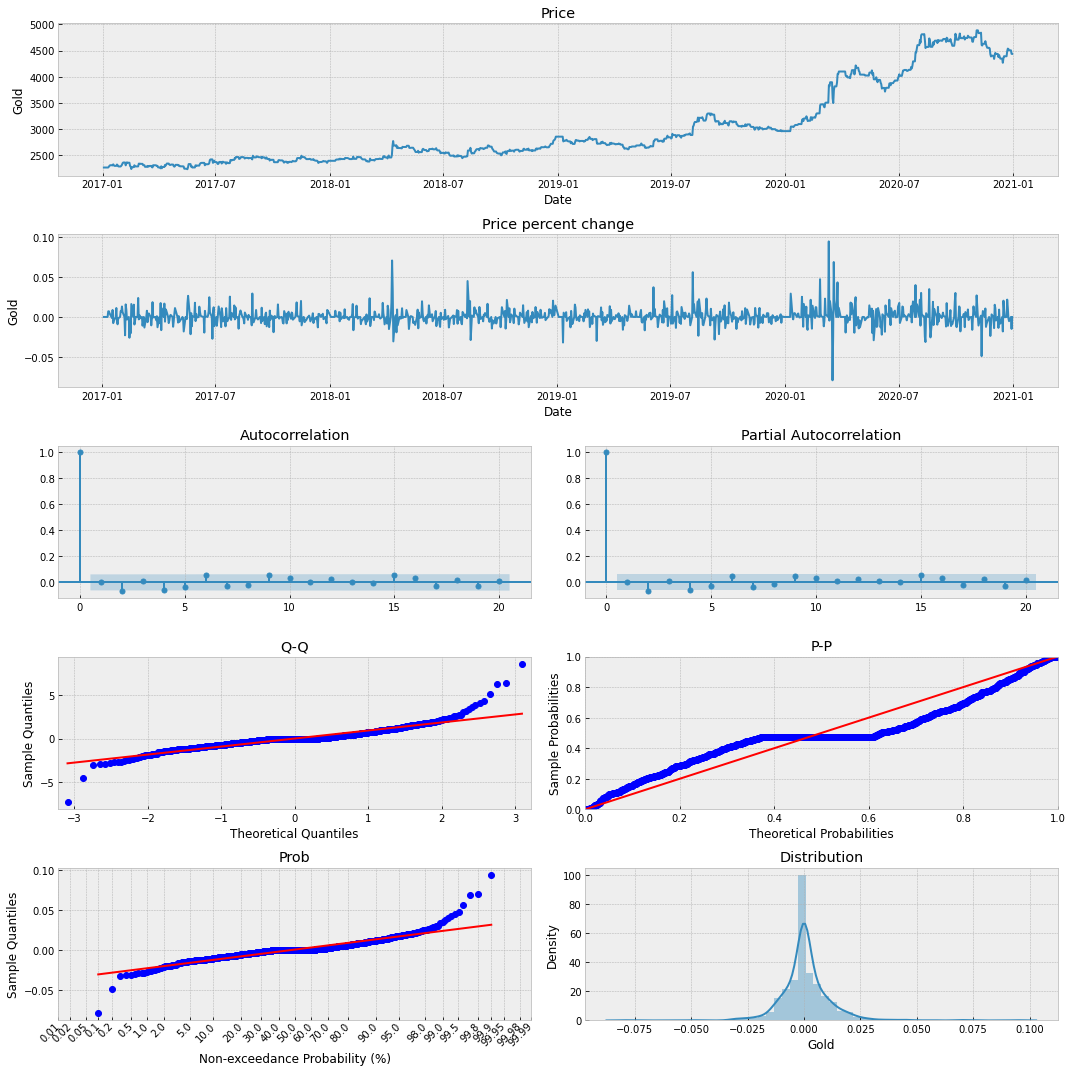

========== ARGENT ==========
mean: 36.29
std: 9.17
min: 29.51
max: 68.34
The Augmented Dickey-Fuller test, p-value: 0.943344377504336, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 6.698866653316022e-11, series is stationary


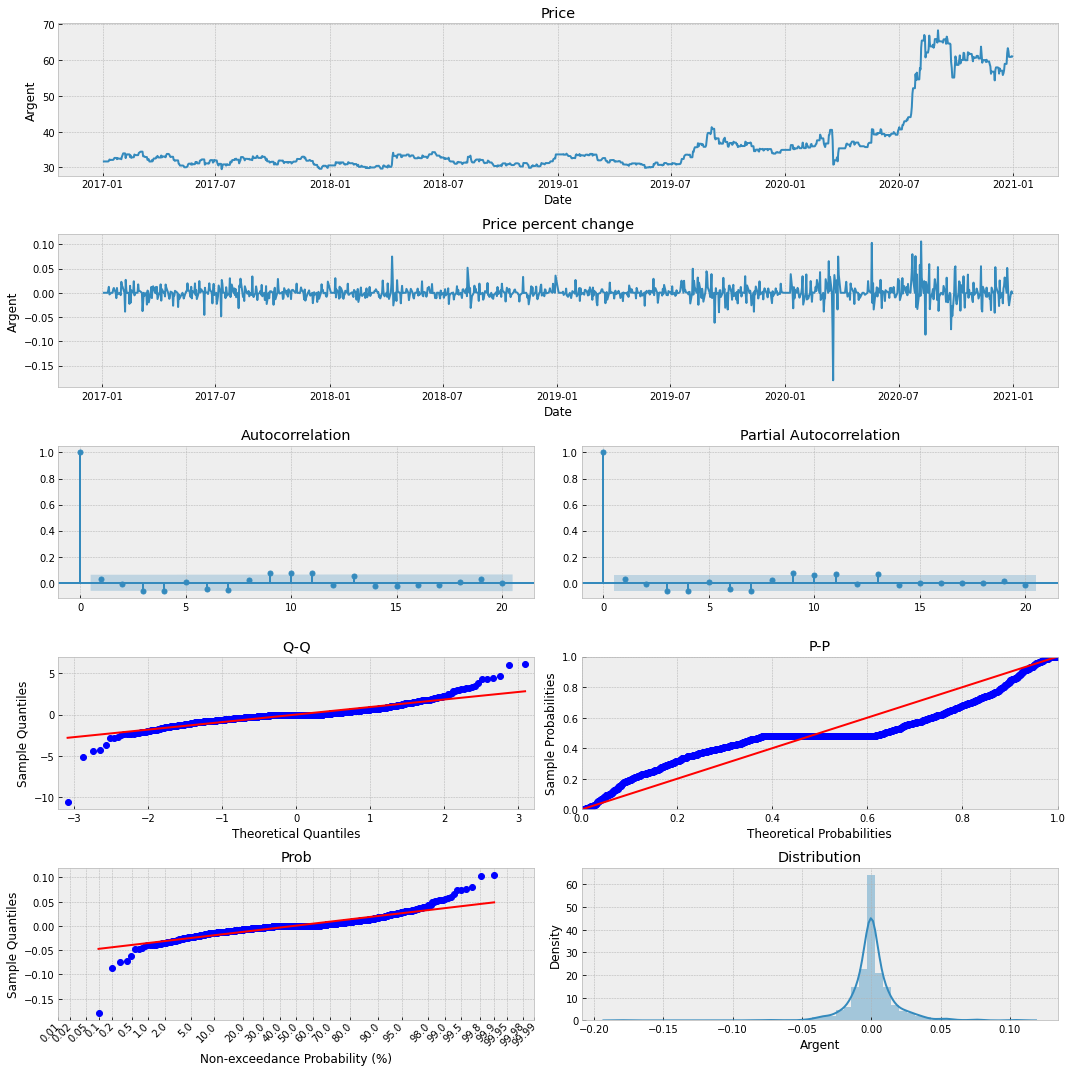

========== PLATINE ==========
mean: 1848.12
std: 170.84
min: 1522.76
max: 2473.81
The Augmented Dickey-Fuller test, p-value: 0.950871410902307, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.274893365112877e-27, series is stationary


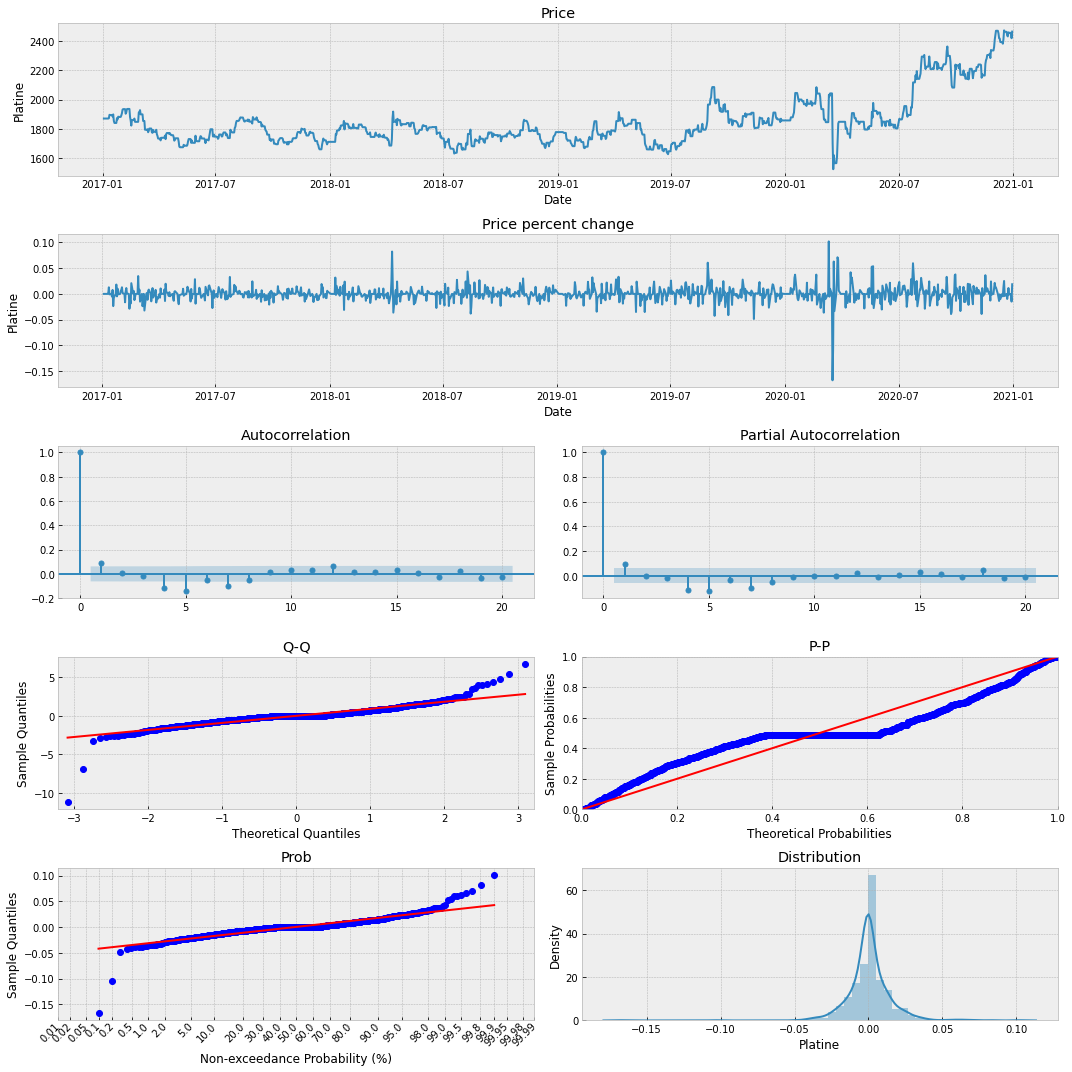

========== PALLADIUM ==========
mean: 2999.15
std: 1393.67
min: 1379.06
max: 6098.86
The Augmented Dickey-Fuller test, p-value: 0.9819060821375514, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.4455303781893872e-24, series is stationary


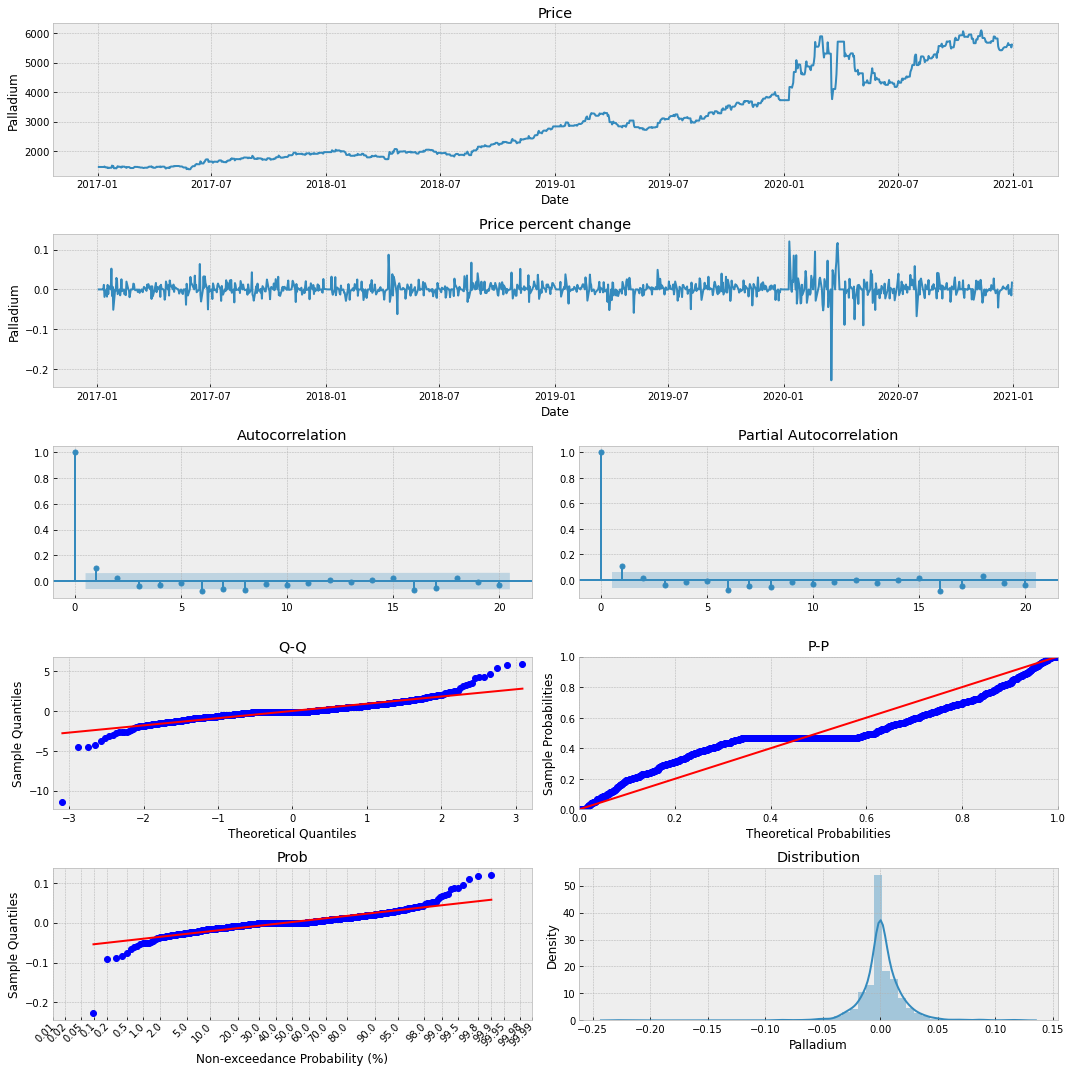

========== 0.25 ==========
mean: 6.62
std: 1.46
min: 3.68
max: 9.82
The Augmented Dickey-Fuller test, p-value: 0.9145344034994012, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


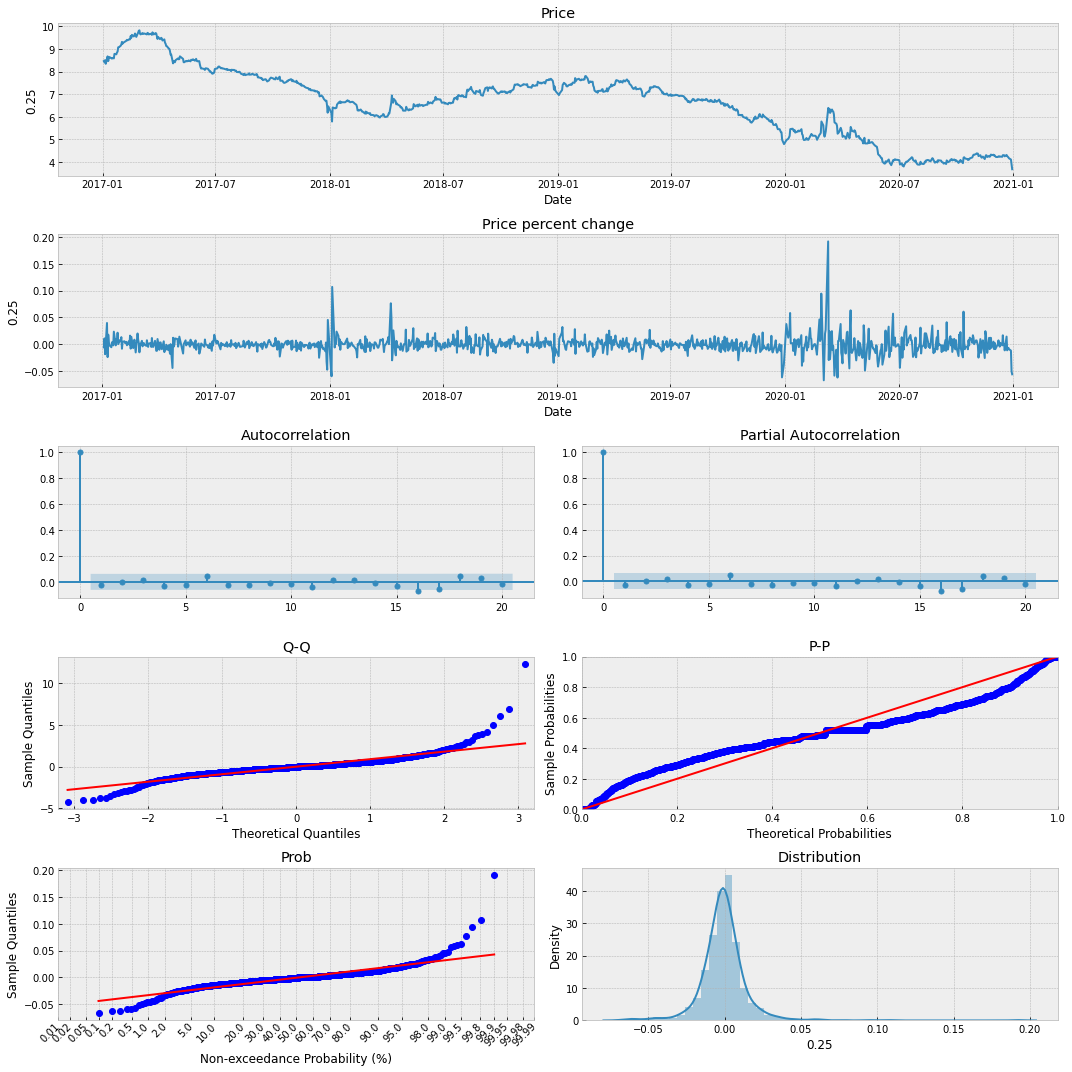

========== 0.5 ==========
mean: 6.64
std: 1.42
min: 3.87
max: 9.51
The Augmented Dickey-Fuller test, p-value: 0.9143124925299795, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


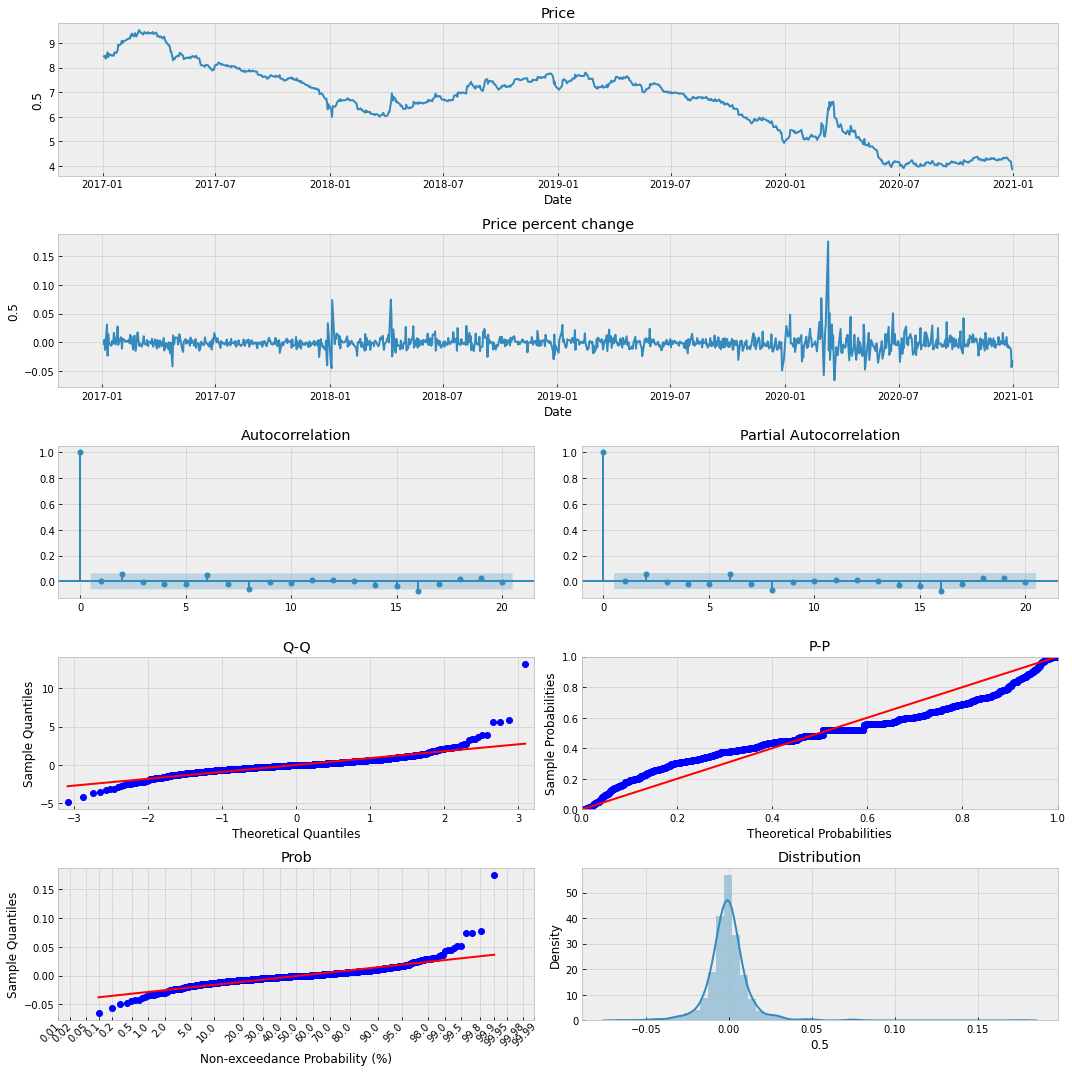

========== 0.75 ==========
mean: 6.66
std: 1.38
min: 4.02
max: 9.27
The Augmented Dickey-Fuller test, p-value: 0.9021490752383663, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.2920823550687052e-21, series is stationary


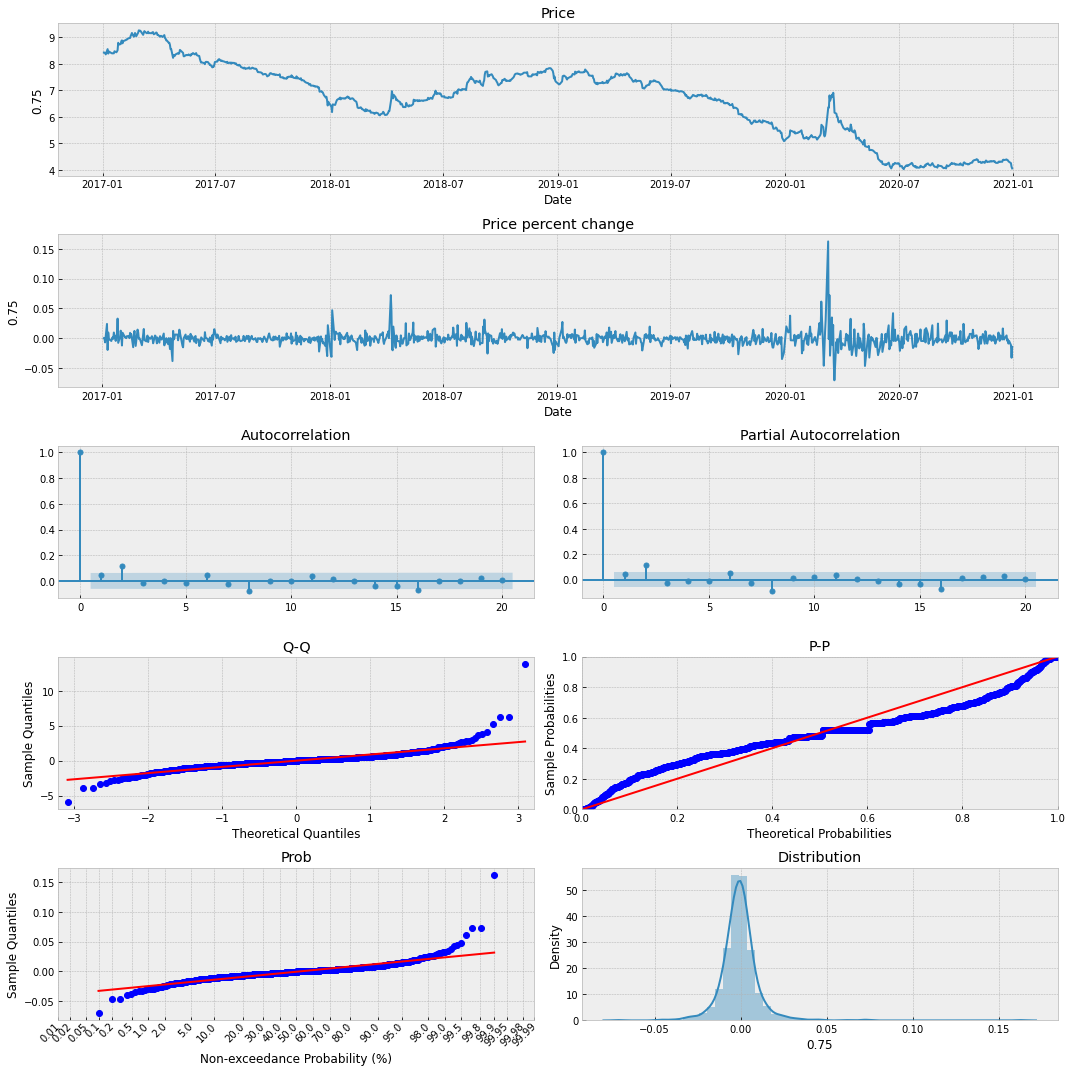

========== 1 ==========
mean: 6.69
std: 1.35
min: 4.12
max: 9.1
The Augmented Dickey-Fuller test, p-value: 0.9242625911753577, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 7.835691975405049e-22, series is stationary


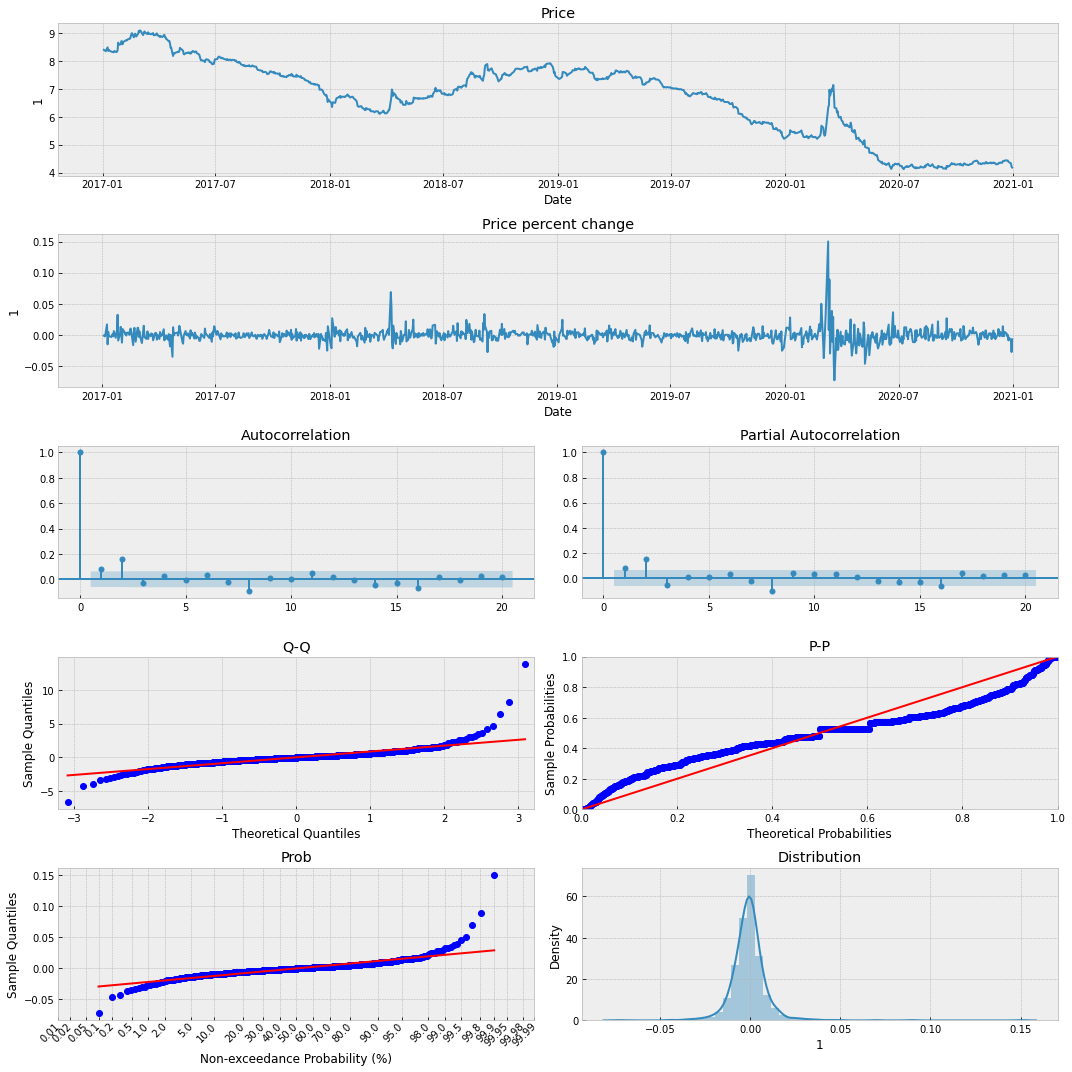

========== 2 ==========
mean: 6.8
std: 1.25
min: 4.38
max: 8.68
The Augmented Dickey-Fuller test, p-value: 0.9097458147543342, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.093441976351696e-21, series is stationary


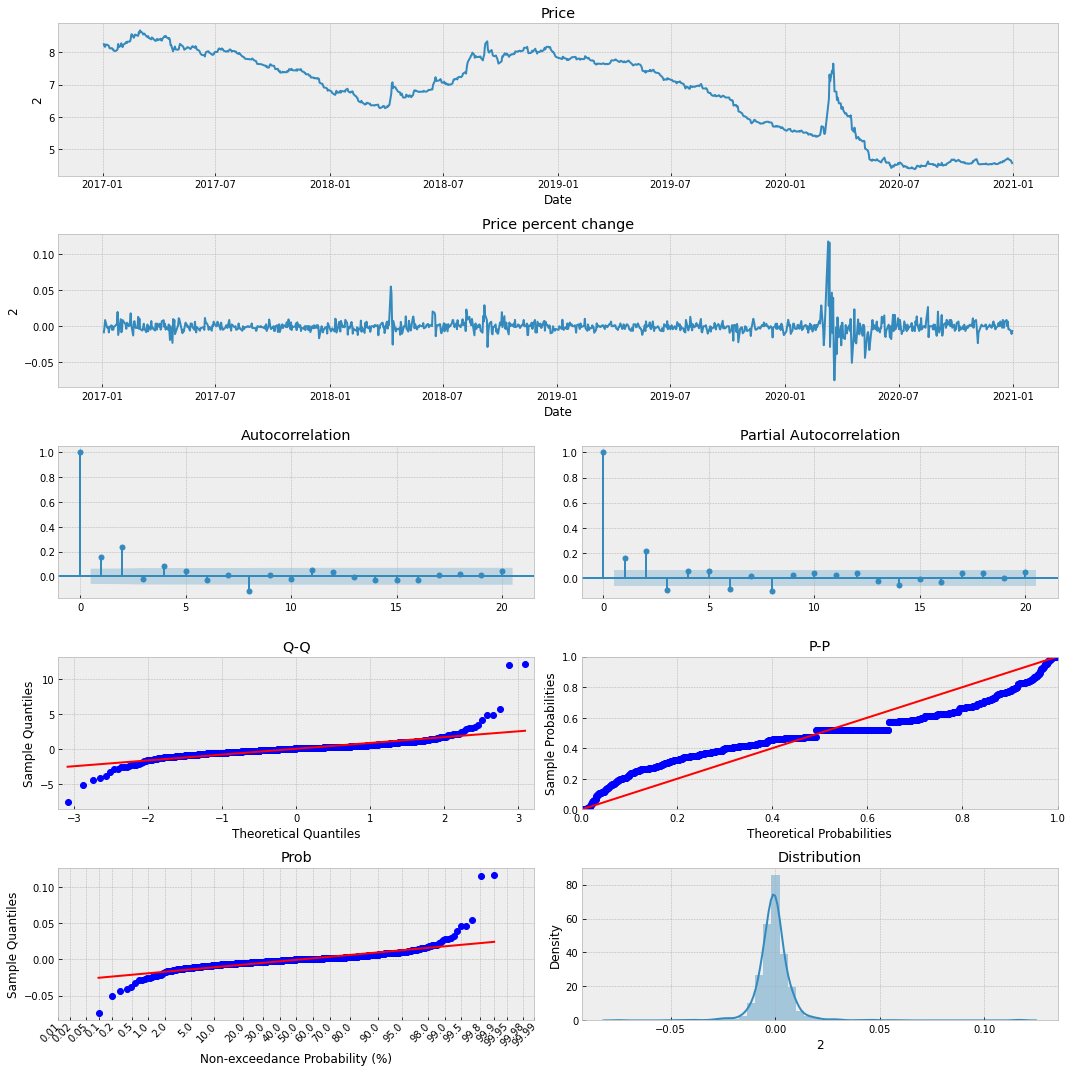

========== 3 ==========
mean: 6.9
std: 1.18
min: 4.6
max: 8.65
The Augmented Dickey-Fuller test, p-value: 0.871143923257319, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.9097597993308758e-20, series is stationary


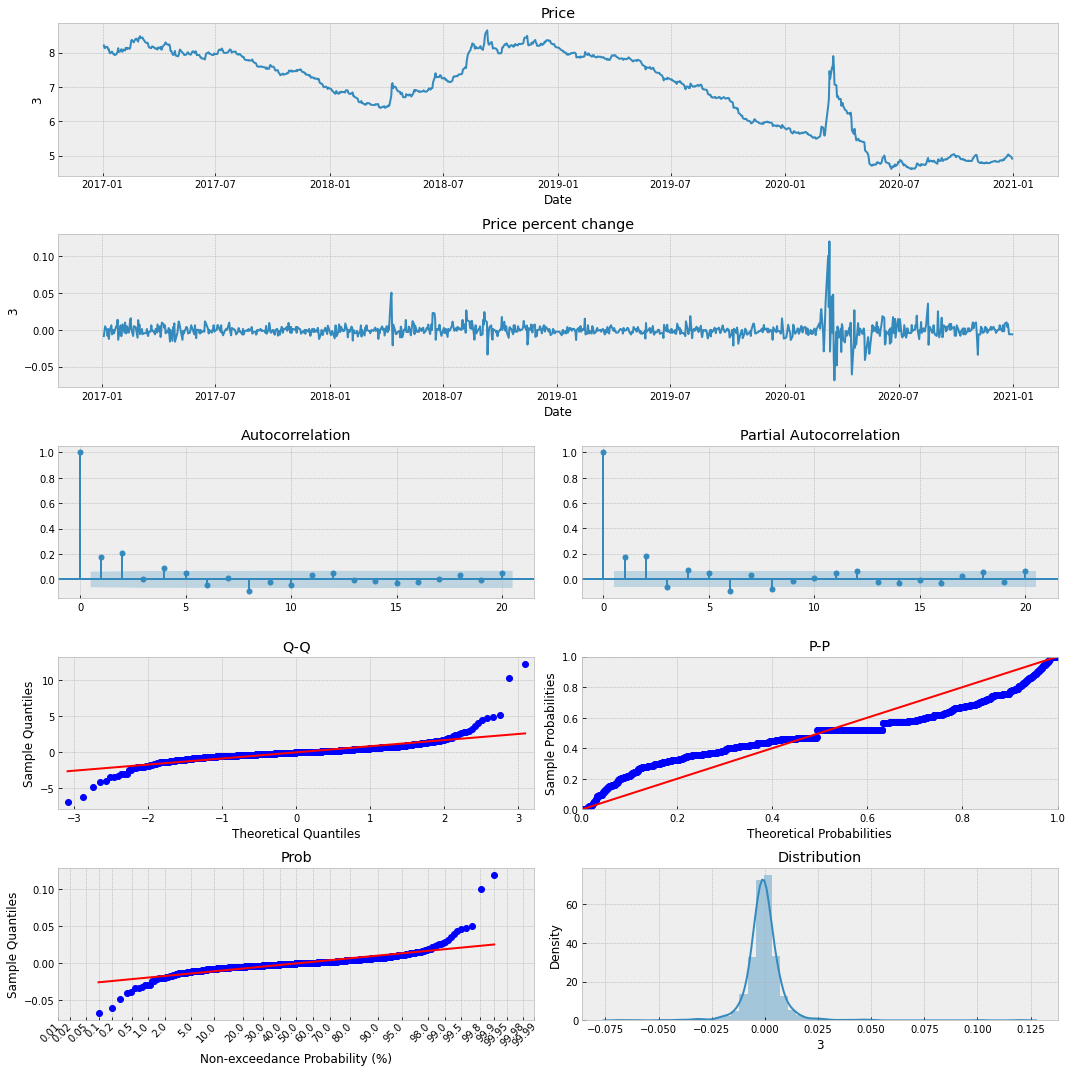

========== 5 ==========
mean: 7.09
std: 1.06
min: 4.95
max: 9.02
The Augmented Dickey-Fuller test, p-value: 0.7514487725858088, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.3857709635609386e-14, series is stationary


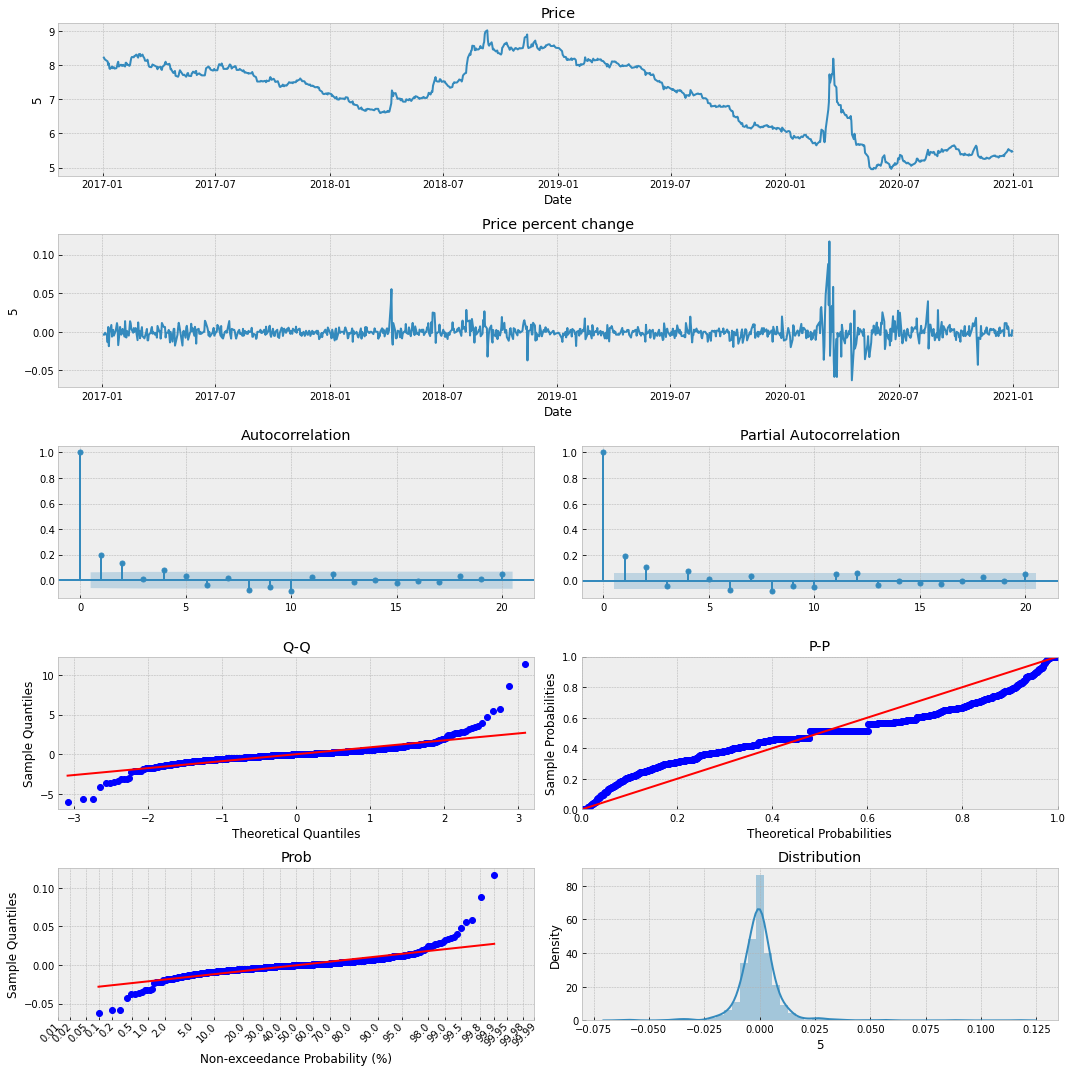

========== 7 ==========
mean: 7.24
std: 0.97
min: 5.22
max: 9.19
The Augmented Dickey-Fuller test, p-value: 0.7010514948984194, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.1238998045579063e-15, series is stationary


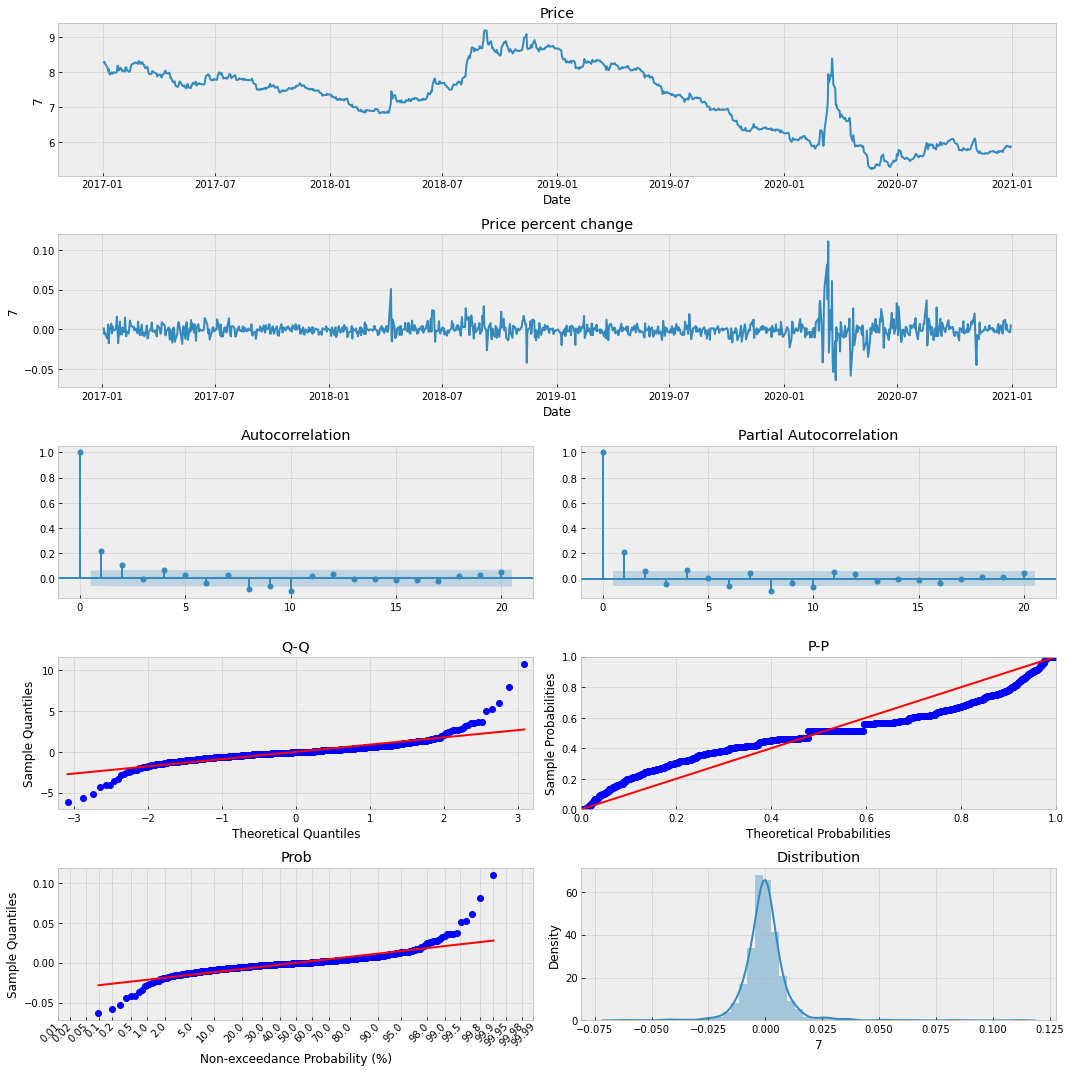

========== 10 ==========
mean: 7.43
std: 0.88
min: 5.59
max: 9.29
The Augmented Dickey-Fuller test, p-value: 0.6629083396090492, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.5376638081806754e-17, series is stationary


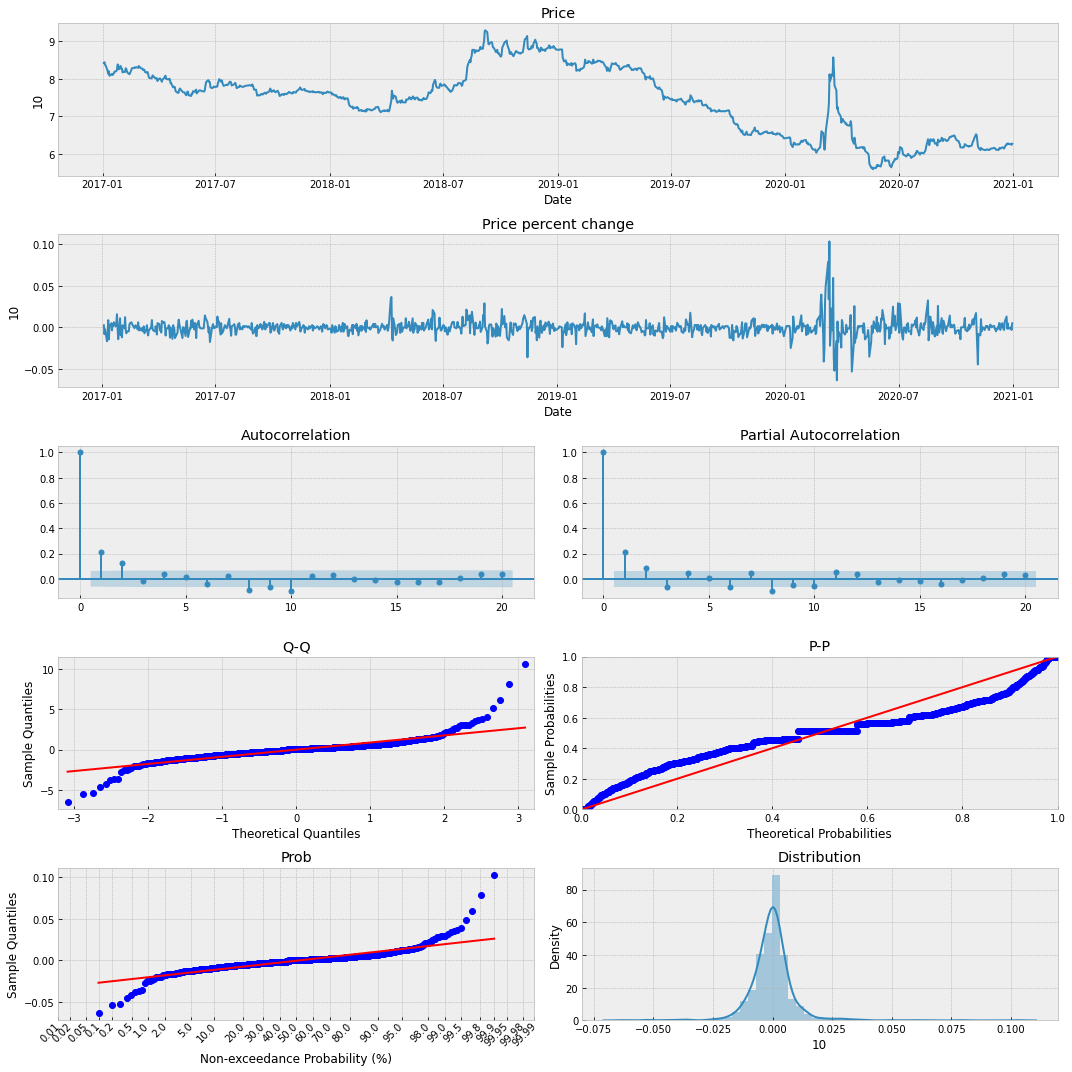

========== 15 ==========
mean: 7.66
std: 0.81
min: 5.97
max: 9.26
The Augmented Dickey-Fuller test, p-value: 0.6139933089641, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.288093762530581e-17, series is stationary


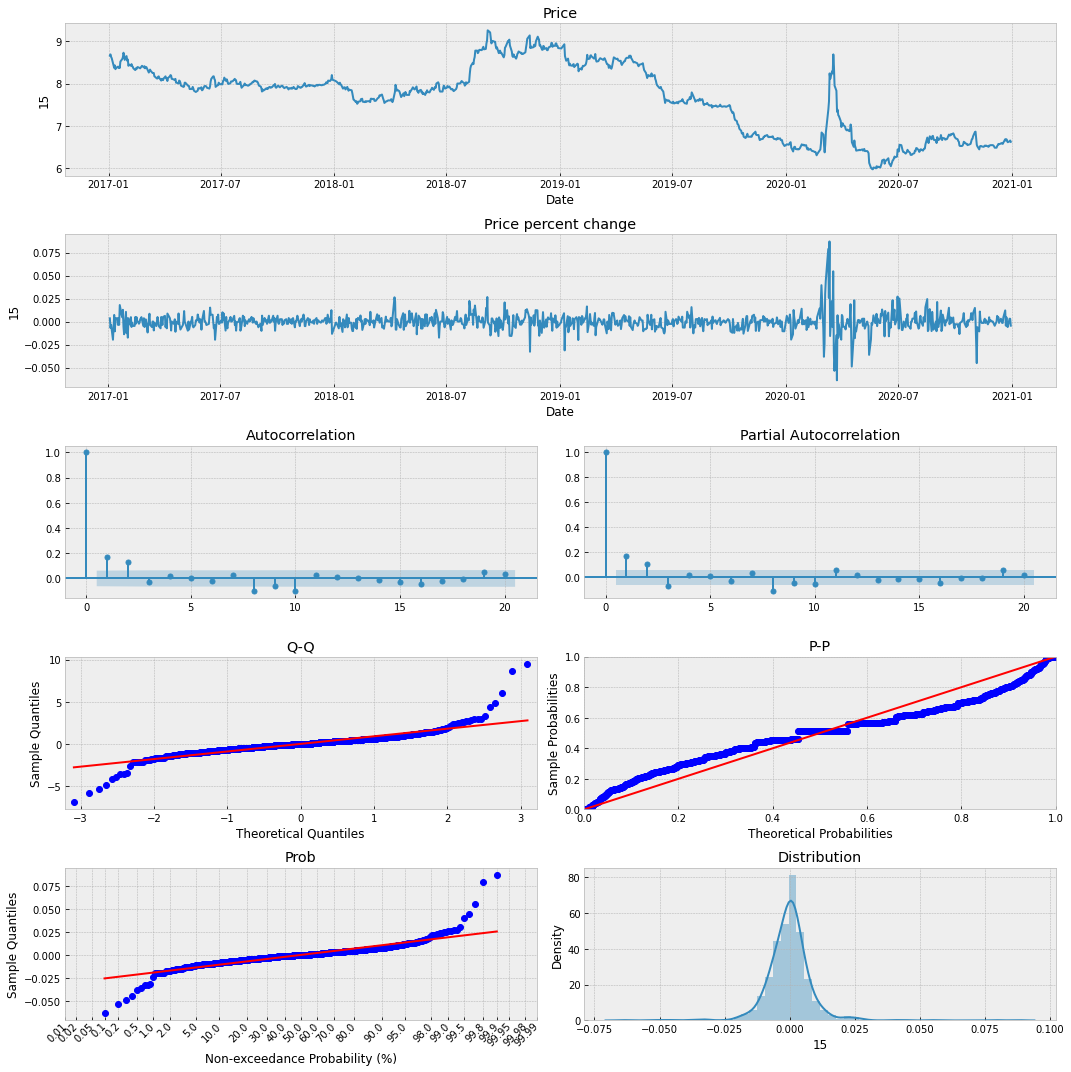

========== 20 ==========
mean: 7.84
std: 0.79
min: 6.17
max: 9.2
The Augmented Dickey-Fuller test, p-value: 0.601541555046818, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 6.250820276205768e-18, series is stationary


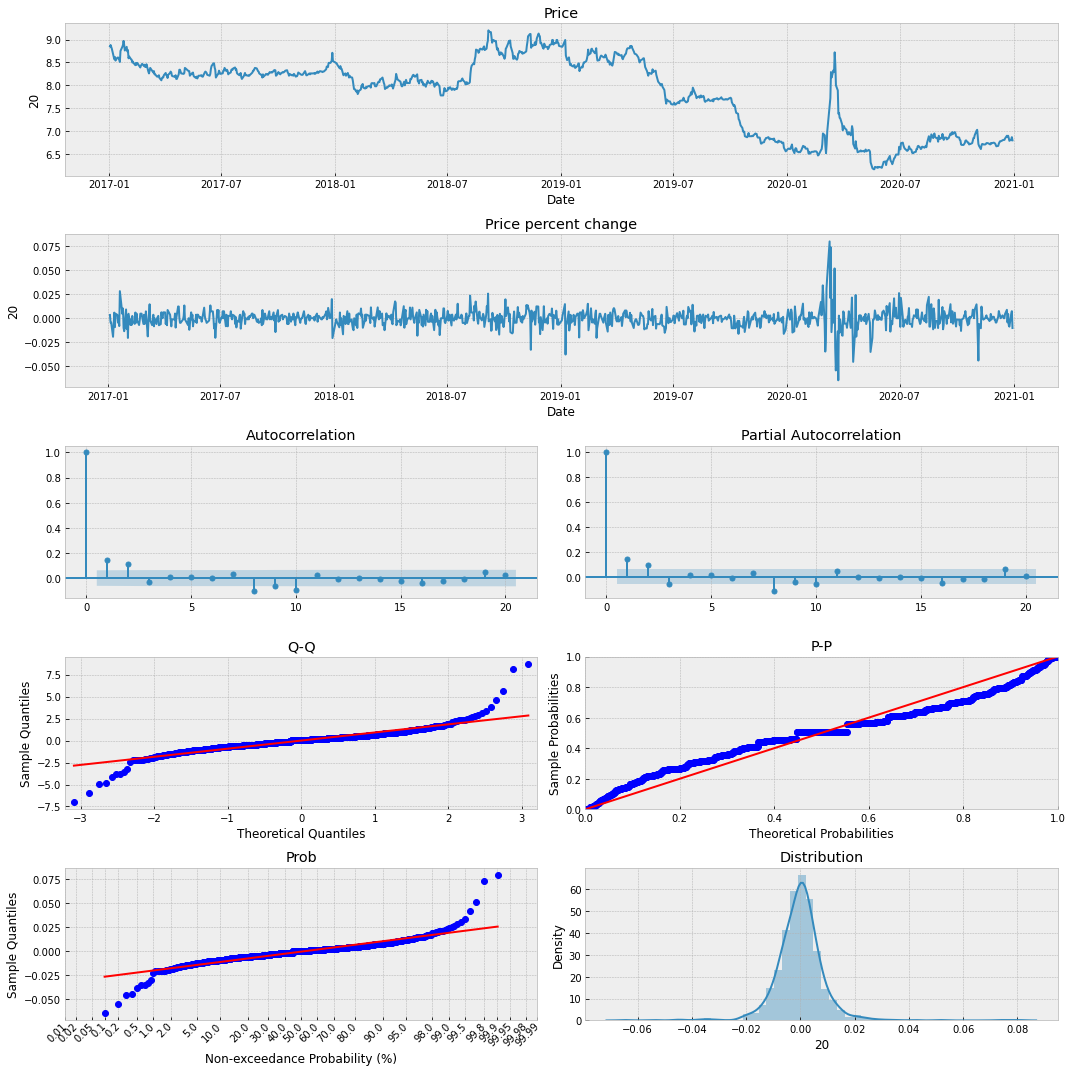

========== 30 ==========
mean: 8.09
std: 0.85
min: 6.37
max: 9.57
The Augmented Dickey-Fuller test, p-value: 0.6419590589333192, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.9450796854748026e-20, series is stationary


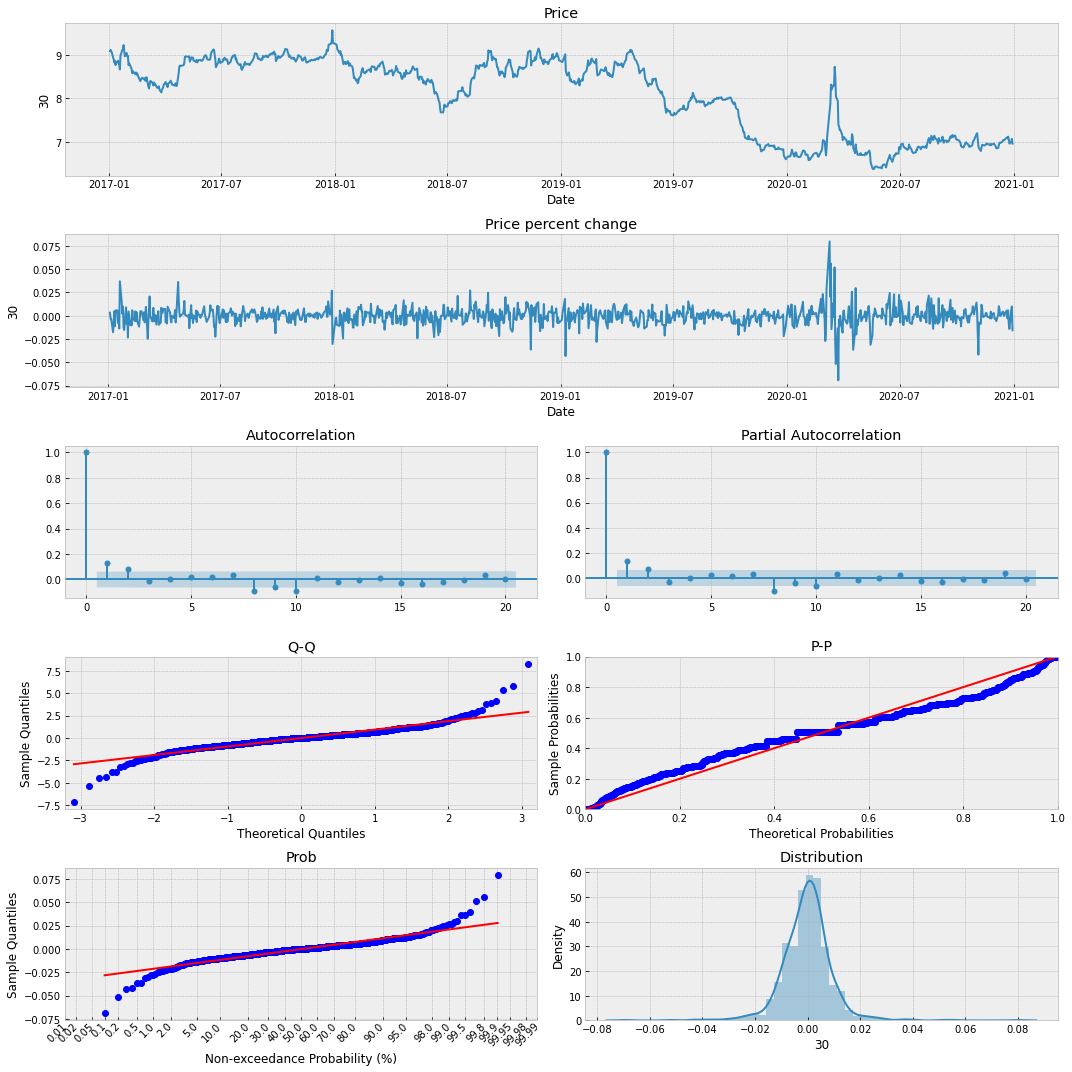

In [31]:
for col in risk_factors.columns:
    risk_factor_describe(risk_factors[col])

# 4. Симуляции риск-факторов

<!-- #### У нас есть три группы риск-факторов: главные компоненты пространства лог.доходностей процентных ставок, лог.доходности индексов, лог.доходности валют и нефти -->

<!-- - Для симуляций главных компонент лог.доходностей проценных ставок будем использовать модель Васичека.
- Для симуляции лог.доходностей индексов и лог.доходностей валют и нефти будем использовать random walk -->

#### Генерация скоррелированных приращений

In [44]:
def get_log(df) -> pd.DataFrame:
    df_log = df.copy()
    for col in df_log.columns:
        if col != "Date":
            df_log[col] = np.log(df_log[col]).diff()
    return df_log

In [31]:
def generate_correlated_dWt(cor_matrix, steps_amount, dt) -> np.ndarray:
    L = np.linalg.cholesky(cor_matrix)
    uncorrelated_dWt = np.random.normal(loc=0.0, scale=1.0, size=(cor_matrix.shape[0], steps_amount)) * np.sqrt(dt)
    return L.dot(uncorrelated_dWt)

Random walk

In [85]:
def gbm_estimation(data):
    mu = np.mean(data)
    sigma_square = (-1 + np.sqrt(1 + ((data - mu) ** 2).sum() / data.shape[0])) / 0.5
    return mu, sigma_square

def gbm_model(pred_param, current_value, dWt, dt):
    mu, sigma_square = pred_param #sigma-sigma alpha=k theta=r
    drift_coef = mu - 0.5 * sigma_square
    new_r = current_value + drift_coef * dt + np.sqrt(sigma_square) * dWt
    return new_r

def get_gbm_pred(current_value, pred_param, dWt) -> list:
    preds = []
    for cur_dwt in dWt:
        cur_dt = 1
        current_value = gbm_model(pred_param, current_value, cur_dwt, cur_dt)
        preds.append(current_value)
    return preds

In [153]:
def simulate_rand(df, day_n, time_horizon) -> np.ndarray:
    n_factors = df.shape[1]
    n_days = time_horizon
    n_sims = 200

    sims_ind = np.zeros((n_factors, n_sims, n_days))

    init_vals = df.values[day_n, :]
    cor_matrix = np.corrcoef(df.T)

    for factor in range(n_factors):
        init_val = init_vals[factor]
        params = gbm_estimation(df.values[:, factor])
        sim = 0
        for sim in range(n_sims):
            dwt = generate_correlated_dWt(cor_matrix, n_days, 1)[factor]
            sims_ind[factor][sim] = get_gbm_pred(init_val, params, dwt)
            
    return sims_ind

Vasicek model

In [108]:
def vasicek_model(pred_param, current_value, dWt, dt):
    sigma, alpha, theta = pred_param #sigma-sigma alpha=k theta=r
    drift_coef = alpha * (theta - current_value)
    new_r = current_value + drift_coef * dt + sigma * dWt
    return new_r

def vasicek_estimation(data):
    dt = 1
    s0 = data[:-1].sum() / data.shape[0]
    s1 = data[1:].sum() / data.shape[0]
    s00 = (data[:-1] * data[:-1]).sum() / data.shape[0]
    s01 =  (data[1:] * data[:-1]).sum() / data.shape[0]
    r_opt = (s1 * s00 - s0*s01) / (s0*s1 - s0 ** 2 -s01 + s00)
    k = (1 / dt)*np.log((s0 - r_opt) / (s1 - r_opt))
    #k = (-1 / dt)*np.log((s01 - r_opt*s0 - r_opt*s1 + data.shape[0]*r_opt**2) / (s00 - 2*r_opt*s0 + data.shape[0]*r_opt**2))
    beta = (1/k) * (1 - np.exp(-k * dt))
    m = r_opt * k * beta + data[:-1] * (1 - k*beta)
    sigma_square = (1 / (data.shape[0] * beta*(1 - 0.5*k*beta))) * ((data[1:] - m) ** 2).sum()
    return sigma_square, k, r_opt

def get_vasicek_pred(current_value, pred_param, dWt, dt) -> list:
    '''if steps_amount == 1:
        dWt = generate_correlated_dWt(cor_matrix, dt)
        new_value = vasicek_model(pred_param, current_value, dWt, dt)
        return new_value
    
    return get_vasicek_pred(new_value, pred_param, cor_matrix, steps_amount - 1, dt)'''
    
    #preds = [current_value]
    preds = []
    #preds = 
    for cur_dwt in dWt:
        cur_dt = 1
        #dWt = np.random.normal(0, 1)
        current_value = vasicek_model(pred_param, current_value, cur_dwt, cur_dt)
        preds.append(current_value)
    return preds

In [109]:
def simulate_vasicek(df, day_n, time_horizon) -> np.ndarray:
    n_factors = df.shape[1]
    n_days = time_horizon
    n_sims = 200

    sims_interest = np.zeros((n_factors, n_sims, n_days))

    init_vals = df.values[day_n, :]
    cor_matrix = np.corrcoef(df.T)

    for factor in range(n_factors):
        init_val = init_vals[factor]
        params = vasicek_estimation(df.values[:, factor])
        sim = 0
        for sim in range(n_sims):
            dwt = generate_correlated_dWt(cor_matrix, n_days, 1)[factor]
            sims_interest[factor][sim] = get_vasicek_pred(init_val, params, dwt, 1)
            
    return sims_interest

Рисуем симуляции

In [131]:
def get_plot_simulation(array, df) -> None:
    for i, col in enumerate(df.columns):
        plt.figure(figsize=(9,6))
        plt.xlim(-0.05, 10)
        plt.title(col, size=18)
        plt.xlabel('time', size=14)
        plt.ylabel('price', size=14)
        plt.plot(array[i].T)
        plt.show()

#### *Процентные ставки ~на спорт~*

In [184]:
interest_rates = risk_factors.iloc[:, 7:]
ir_log = get_log(interest_rates).dropna(axis=0)

In [186]:
ir_log.corr()

0.25       0.5      0.75         1         2         3         5  \
0.25  1.000000  0.971786  0.899444  0.806872  0.476414  0.372150  0.314844   
0.5   0.971786  1.000000  0.972789  0.914737  0.622017  0.503804  0.431148   
0.75  0.899444  0.972789  1.000000  0.978043  0.752665  0.630974  0.545124   
1     0.806872  0.914737  0.978043  1.000000  0.851430  0.733204  0.635194   
2     0.476414  0.622017  0.752665  0.851430  1.000000  0.955801  0.860519   
3     0.372150  0.503804  0.630974  0.733204  0.955801  1.000000  0.952701   
5     0.314844  0.431148  0.545124  0.635194  0.860519  0.952701  1.000000   
7     0.307933  0.421086  0.528819  0.610890  0.808560  0.898859  0.979376   
10    0.327436  0.437269  0.538303  0.612392  0.782238  0.856215  0.936627   
15    0.322034  0.421148  0.511652  0.575340  0.722626  0.778395  0.842522   
20    0.302018  0.388272  0.468247  0.522831  0.653034  0.698633  0.752654   
30    0.262565  0.330773  0.394544  0.437440  0.543211  0.581664  0.631546   

             7        10        15        20        30  
0.25  0.307933  0.327436  0.322034  0.302018  0.262565  
0.5   0.421086  0.437269  0.421148  0.388272  0.330773  
0.75  0.528819  0.538303  0.511652  0.468247  0.394544  
1     0.610890  0.612392  0.575340  0.522831  0.437440  
2     0.808560  0.782238  0.722626  0.653034  0.543211  
3     0.898859  0.856215  0.778395  0.698633  0.581664  
5     0.979376  0.936627  0.842522  0.752654  0.631546  
7     1.000000  0.975761  0.891450  0.800736  0.676951  
10    0.975761  1.000000  0.954573  0.878956  0.761390  
15    0.891450  0.954573  1.000000  0.974488  0.897426  
20    0.800736  0.878956  0.974488  1.000000  0.965297  
30    0.676951  0.761390  0.897426  0.965297  1.000000

In [187]:
from sklearn.decomposition import PCA

In [188]:
for n in range(ir_log.shape[1]):
    dim_red = PCA(n_components = n + 1)
    dim_red.fit(ir_log)
    print(" {} component(s)\n explained variance: {}".format(n + 1, np.sum(dim_red.explained_variance_ratio_))) 

 1 component(s)
 explained variance: 0.6780849292951864
 2 component(s)
 explained variance: 0.9088894837712034
 3 component(s)
 explained variance: 0.9669646967686473
 4 component(s)
 explained variance: 0.9874861187245189
 5 component(s)
 explained variance: 0.9949896795651653
 6 component(s)
 explained variance: 0.9976056959944004
 7 component(s)
 explained variance: 0.9984672888428255
 8 component(s)
 explained variance: 0.9988817316794666
 9 component(s)
 explained variance: 0.9992213107540859
 10 component(s)
 explained variance: 0.9995381192484719
 11 component(s)
 explained variance: 0.9998061343046831
 12 component(s)
 explained variance: 1.0


#### Оставим 3 главные компоненты, так как это минимальное кол-во компонент, объясняюшее больше 95% дисперсии.

In [194]:
PCA_ir = PCA(n_components=3)
ir_pca = pd.DataFrame(PCA_ir.fit_transform(ir_log), columns=['comp_1', 'comp_2', 'comp_3'])

In [195]:
sim_ir_rand = simulate_rand(ir_pca , 0, 10)
sim_ir_vas = simulate_vasicek(ir_pca , 0, 10)

<ipython-input-108-e0b88f438fe2>:14: RuntimeWarning: invalid value encountered in log
  k = (1 / dt)*np.log((s0 - r_opt) / (s1 - r_opt))


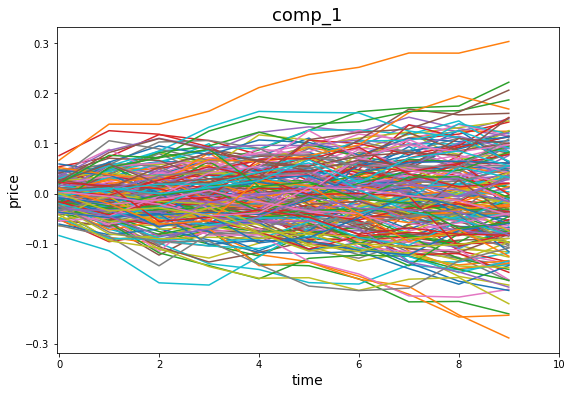

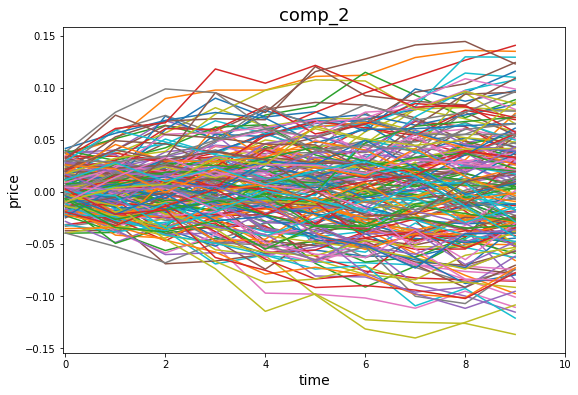

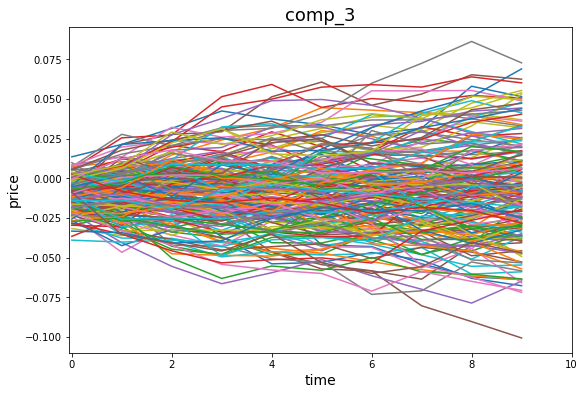

In [196]:
get_plot_simulation(sim_ir_rand, ir_pca)

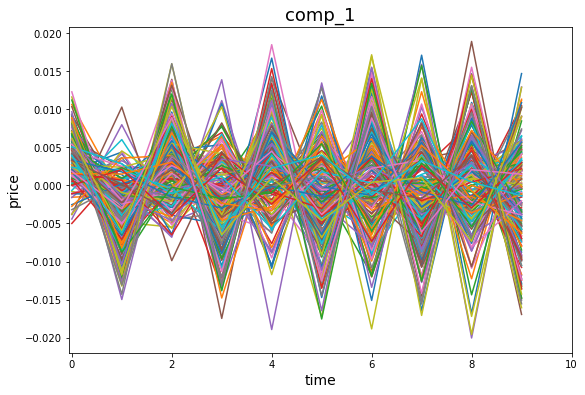

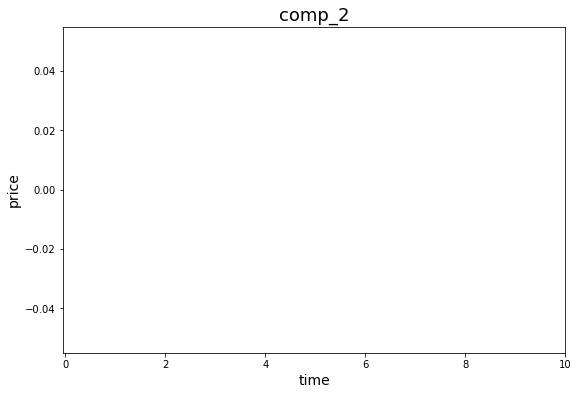

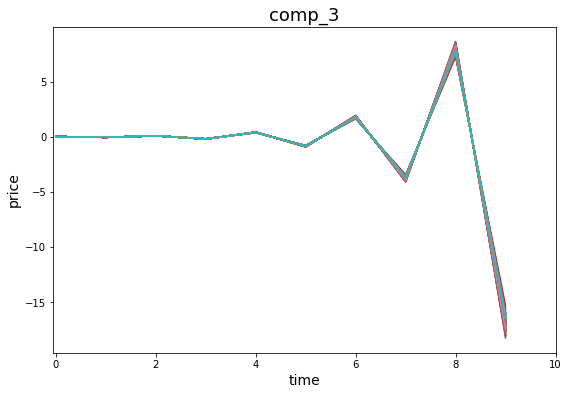

In [197]:
get_plot_simulation(sim_ir_vas, ir_pca)

#### *Драгоценные металы*

In [168]:
metal = risk_factors[['Gold', 'Argent', 'Platine', 'Palladium']]
metal_log = get_log(metal).dropna(axis=0)

In [147]:
sim_met_rand = simulate_rand(metal_log, 0, 10)

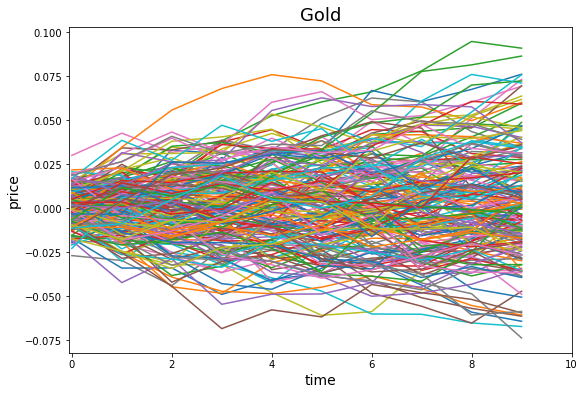

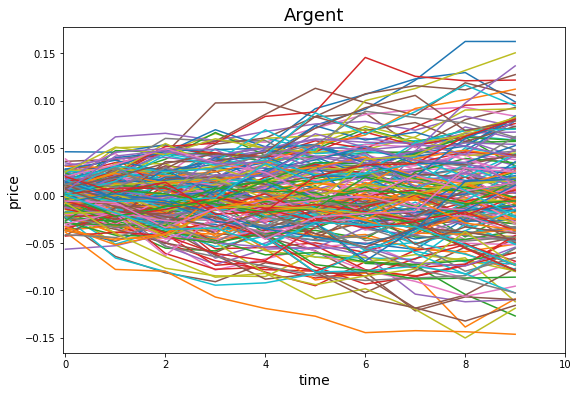

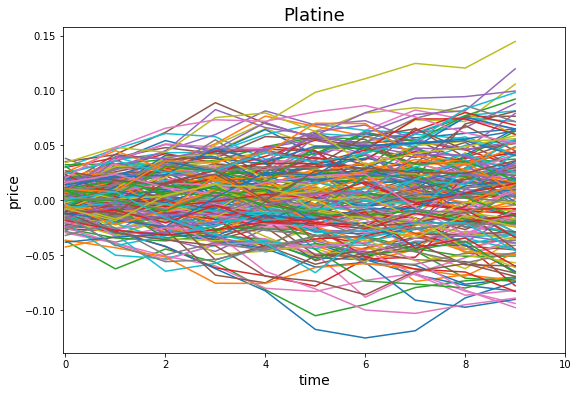

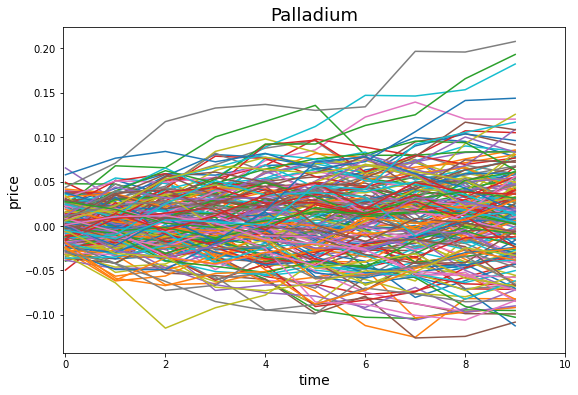

In [148]:
# Рандомный Волк
get_plot_simulation(sim_met_rand, metal)

#### *Индексы*

In [154]:
idx_df = risk_factors[['IMOEX.ME', 'RTS']]
idx_df_log = get_log(idx_df).dropna(axis=0)

In [136]:
sim_idx_rand  = simulate_rand(idx_df_log, 0, 10)

<ipython-input-108-e0b88f438fe2>:14: RuntimeWarning: invalid value encountered in log
  k = (1 / dt)*np.log((s0 - r_opt) / (s1 - r_opt))


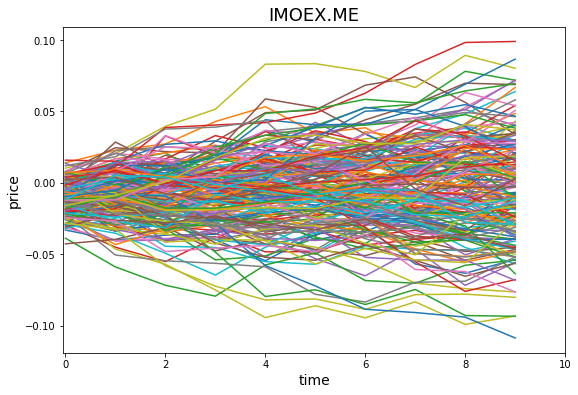

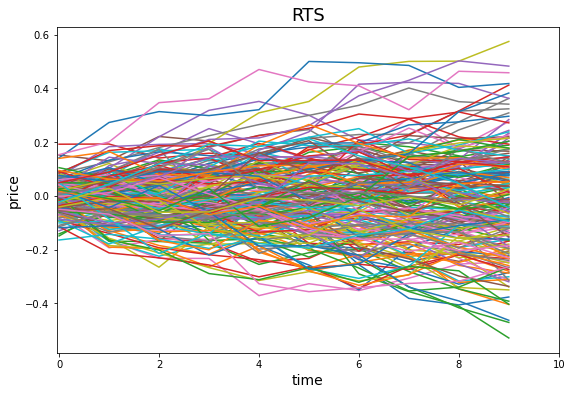

In [137]:
get_plot_simulation(sim_idx_rand, idx_df)

#### *Черное Золото и валюта*

In [247]:
oil = get_log(risk_factors[['BZ=F']]).dropna(axis=0)

In [259]:
np.corrcoef(oil.T)

1.0

In [242]:
cur_oil_df = pd.concat([currencies, risk_factors[['BZ=F']]], axis=1)
cur_oil_df_log = get_log(cur_oil_df).dropna(axis=0)

In [243]:
sim_cur_oil_rand  = simulate_rand(cur_oil_df_log, 0, 10)

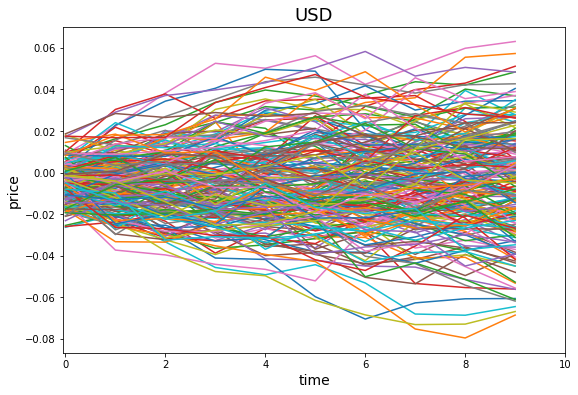

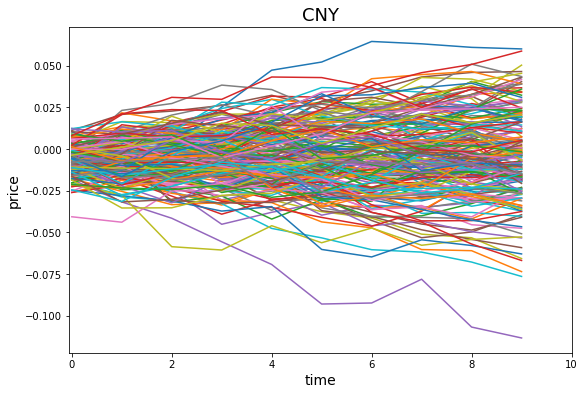

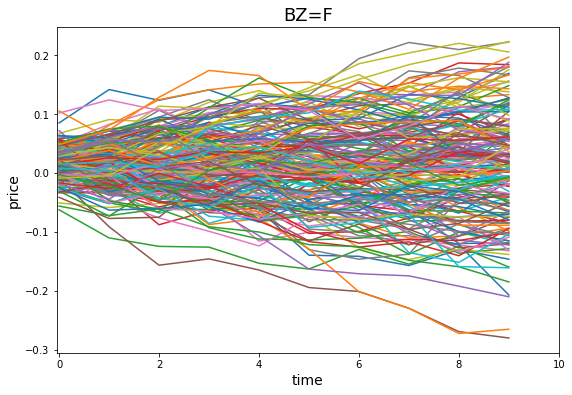

In [244]:
get_plot_simulation(sim_cur_oil, cur_oil_df)

### Что-то с Акциями

In [93]:
import sklearn
from sklearn.linear_model import LinearRegression

In [216]:
scaler = StandardScaler()
scaled_indexes = pd.DataFrame(scaler.fit_transform(risk_factors[['IMOEX.ME', 'RTS']]), 
                              columns=risk_factors[['IMOEX.ME', 'RTS']].columns,
                             index=risk_factors.index)

scaled_rates = pd.DataFrame(scaler.fit_transform(risk_factors.iloc[:, 7:]), 
                                                 columns=risk_factors.iloc[:, 7:].columns, 
                                                 index=risk_factors.index)
                            
scaled_raw = pd.DataFrame(scaler.fit_transform(risk_factors[['BZ=F']]), 
                          columns=risk_factors[['BZ=F']].columns, 
                          index=risk_factors.index)
                            
scaled_curr = pd.DataFrame(scaler.fit_transform(currencies), columns=currencies.columns, 
                           index=currencies.index)

In [241]:
risk_factors

IMOEX.ME       BZ=F      RTS     Gold  Argent  Platine  \
Date                                                                    
2017-01-03  2285.429932  55.470001  1109.39  2264.82   31.68  1869.86   
2017-01-04  2263.899902  56.459999  1109.39  2264.82   31.68  1869.86   
2017-01-05  2220.350098  56.889999  1109.39  2264.82   31.68  1869.86   
2017-01-06  2213.929932  57.099998  1045.63  2264.82   31.68  1869.86   
2017-01-09  2211.250000  54.939999  1100.58  2264.82   31.68  1869.86   
...                 ...        ...      ...      ...     ...      ...   
2020-12-24  3236.879883  51.200001  1378.33  4529.59   62.52  2459.96   
2020-12-25  3236.879883  51.200001  1378.36  4505.61   60.91  2456.66   
2020-12-28  3258.949951  50.860001  1391.31  4505.61   60.91  2456.66   
2020-12-29  3274.669922  51.090000  1398.48  4438.08   61.10  2419.84   
2020-12-30  3289.020020  51.340000  1387.46  4437.61   61.05  2465.21   

            Palladium  0.25   0.5  0.75     1     2     3     5     7    10  \
Date                                                                          
2017-01-03    1455.83  8.46  8.45  8.43  8.40  8.25  8.21  8.22  8.28  8.42   
2017-01-04    1455.83  8.41  8.43  8.43  8.39  8.18  8.14  8.19  8.29  8.44   
2017-01-05    1455.83  8.50  8.47  8.42  8.37  8.17  8.13  8.16  8.24  8.37   
2017-01-06    1455.83  8.34  8.36  8.36  8.35  8.24  8.17  8.15  8.21  8.35   
2017-01-09    1455.83  8.67  8.62  8.56  8.49  8.23  8.16  8.11  8.12  8.21   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2020-12-24    5667.14  4.20  4.26  4.32  4.39  4.70  5.03  5.54  5.89  6.27   
2020-12-25    5601.48  4.16  4.23  4.30  4.37  4.68  5.00  5.51  5.88  6.26   
2020-12-28    5601.48  4.11  4.18  4.25  4.33  4.65  4.97  5.49  5.86  6.26   
2020-12-29    5517.53  3.90  4.00  4.11  4.21  4.60  4.94  5.46  5.84  6.24   
2020-12-30    5612.44  3.68  3.87  4.05  4.18  4.57  4.91  5.47  5.87  6.27   

              15    20    30  
Date                          
2017-01-03  8.66  8.85  9.09  
2017-01-04  8.69  8.88  9.12  
2017-01-05  8.63  8.84  9.09  
2017-01-06  8.60  8.80  9.06  
2017-01-09  8.43  8.63  8.90  
...          ...   ...   ...  
2020-12-24  6.65  6.85  7.06  
2020-12-25  6.61  6.79  6.96  
2020-12-28  6.63  6.82  7.00  
2020-12-29  6.65  6.87  7.07  
2020-12-30  6.62  6.80  6.96  

[1008 rows x 19 columns]

In [221]:
pca = PCA(n_components = 1)
reduced_indexes = pca.fit_transform(scaled_indexes)
print(pca.explained_variance_ratio_)
reduced_rates = pca.fit_transform(scaled_rates)
print(pca.explained_variance_ratio_)
reduced_curr = pca.fit_transform(scaled_curr)
print(pca.explained_variance_ratio_)

[0.84307382]
[0.92746791]
[0.96847006]


In [222]:
scaled = pd.concat([scaled_indexes,scaled_rates,scaled_raw,scaled_curr], axis=1).dropna().sort_index(ascending=False)

In [226]:
reduced_data = pd.DataFrame(np.hstack([reduced_indexes,reduced_rates,scaled_raw,reduced_curr])\
             ,columns=['reduced_indexes','reduced_rates','reduced_raw','reduced_curr'], index=risk_factors.index)

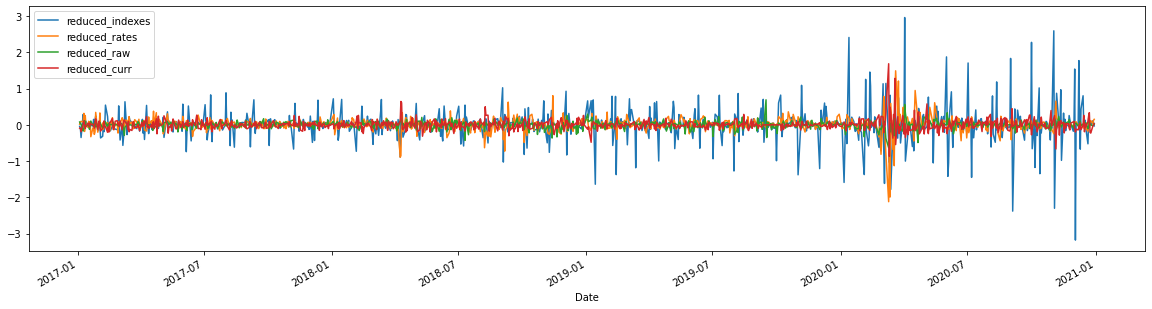

In [228]:
reduced_data.diff().dropna().plot(figsize=(20, 5))
plt.show()

In [105]:
def gbm_sim(data, T, N):
    
# T - number of periods to simulate
# N - number of scenarios

    r = data.diff().values[1:]
    mu = np.mean(r) 
    
    sigma = np.sqrt((-1 + np.sqrt(1 + 1/(len(r)) * np.sum((r - mu)**2)))*2)

    epsilon = np.random.normal(size=[T, N])
    paths = data.iloc[0]*np.exp(np.cumsum(mu-0.5*sigma*sigma + sigma*epsilon, axis=0))

    return paths
# source - https://www.duo.uio.no/bitstream/handle/10852/37727/ChristensenJCJ-master.pdf?sequence=2&isAllowed=y

In [229]:
paths_dict = dict()

for name in reduced_data.columns:
    paths_dict[name] = gbm_sim(reduced_data[name],10,1000)

In [230]:
scaler = StandardScaler()

scale_shares = shares.copy()
for col in shares.columns:
    scale_shares.loc[:, col] = scale.fit_transform(shares[[col]])
    

In [237]:
shares_log = shares.copy()

shares_log = np.log(shares_log)

In [239]:
stocks_forecast = {}
for name in shares_log.columns:
    LR = LinearRegression(n_jobs=8)
    LR.fit(reduced_data, shares_log[name].to_numpy())
    forecast = []
    for i in range(1000):
        pred = LR.predict(np.vstack([paths_dict['reduced_indexes'].T[i], 
                                     paths_dict['reduced_rates'].T[i], 
                                     paths_dict['reduced_raw'].T[i], 
                                     paths_dict['reduced_curr'].T[i]]).T)
        forecast.append(pred)
    stocks_forecast[name] = forecast

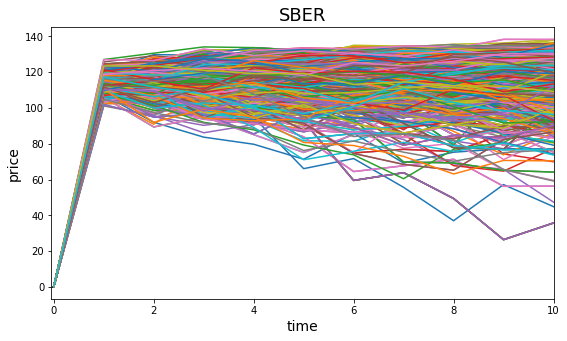

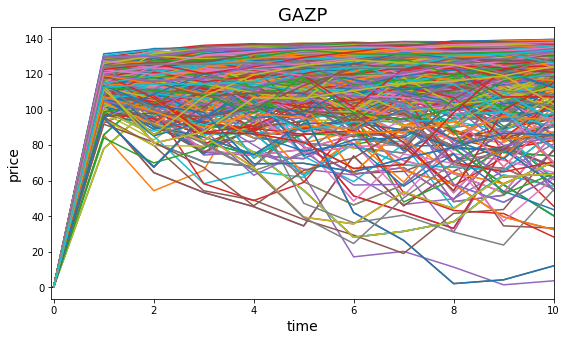

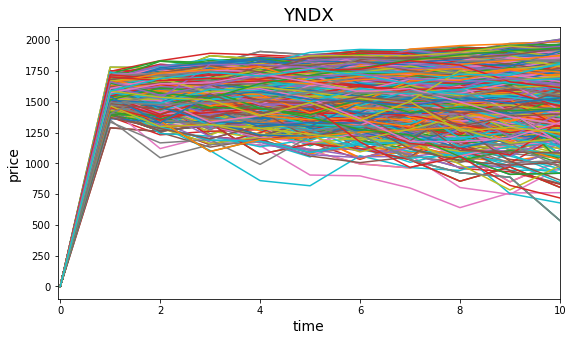

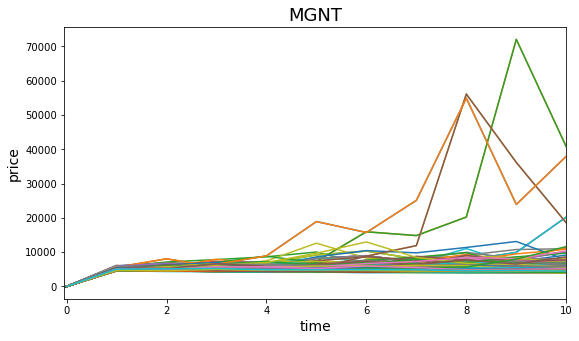

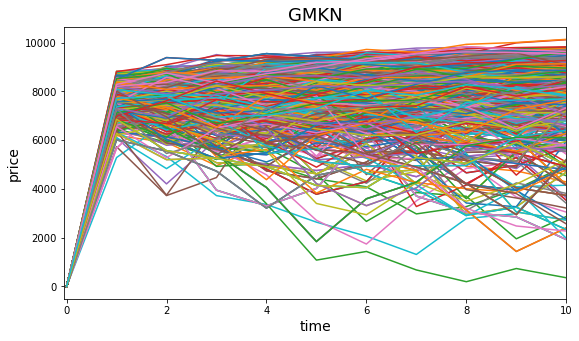

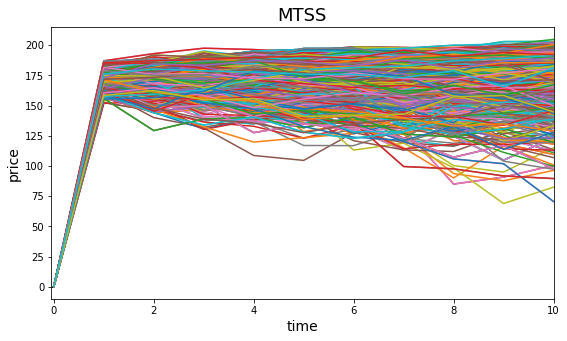

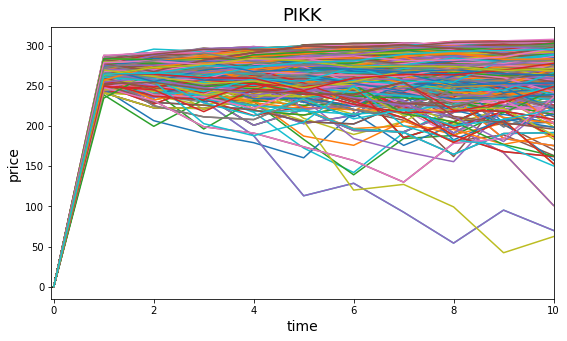

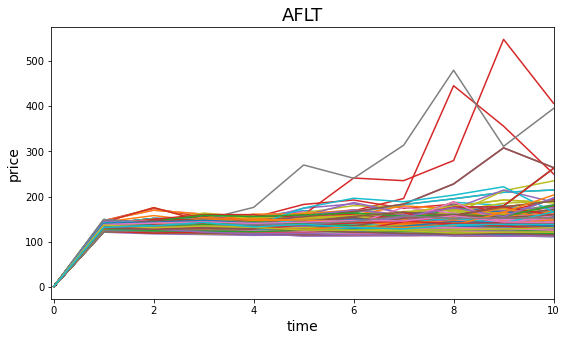

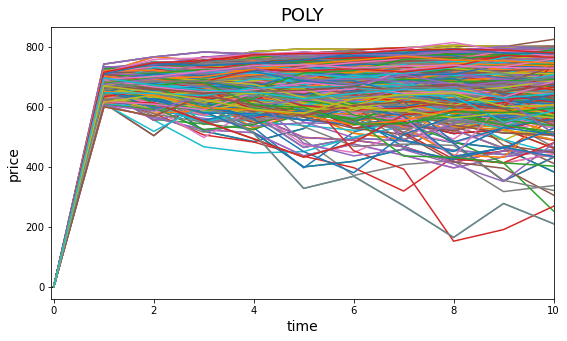

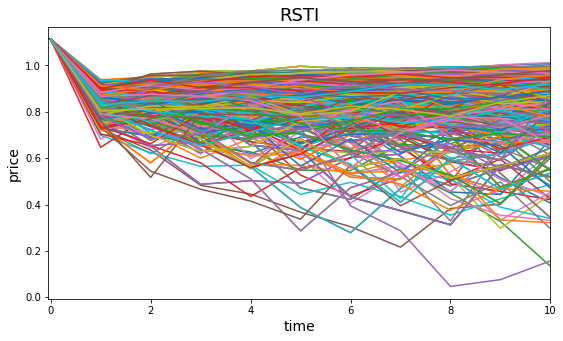

In [240]:
for i in scale_shares.columns:
    plt.figure(figsize=(9,5))
    plt.xlim(-0.05, 10)
    plt.title(i, size=18)
    plt.xlabel('time', size=14)
    plt.ylabel('price', size=14)
    
    for _ in range(1000):
        tmp = np.zeros(11)
        tmp[0] = scale_shares[i][0]
        tmp[1:] = stocks_forecast[i][np.random.randint(1000)].reshape(10)
        plt.plot(np.exp(tmp))
    plt.show()

# 5. Составляем портфель и перебалансируем на каждый день

In [32]:
obligation_coupons_files = ['bonds\SU26205RMFS3.csv', 'bonds\SU26209RMFS5.csv', 'bonds\SU26212RMFS9.csv', 
                            'bonds\SU26215RMFS2.csv', 'bonds\SU26217RMFS8.csv']
def payment_per_day_bonds(obligation_coupons_files=obligation_coupons_files):

    obligation_coupons = []
    for i in range(len(obligation_coupons_files)):
        obligation_coupon = pd.read_csv(obligation_coupons_files[i])
        obligation_coupon.date = pd.to_datetime(obligation_coupon.date)
        days = (obligation_coupon[['date']].iloc[-2] \
                - obligation_coupon[['date']].iloc[-3]).values[0].astype('timedelta64[D]').astype(int)
        payment_per_day = obligation_coupon['payment'].iloc[-2] / days
        obligation_coupons.append(payment_per_day)

    return np.round(obligation_coupons, 5)

In [33]:
def calculate_portfolio_distribution(bonds=bonds, 
                                     shares=shares, 
                                     currencies=currencies):
    
    dirty_bonds = bonds + payment_per_day_bonds()
    df_for_portfolio = dirty_bonds.join((shares, currencies), how='left')
    
    position_0 = np.array([10e6] * 5 + [1e6] * 10 + [10e6] * 2)
    day_prices = df_for_portfolio.iloc[0] 
    true_qty = position_0 / day_prices
    qty = np.round(position_0 / day_prices, 0).astype(int)
    portfolio_qty_shares_true = (true_qty * day_prices) / (true_qty * day_prices).sum()
    
    all_qty = qty
    all_price = day_prices
    
    for t in range(1, df_for_portfolio.shape[0]):
        day_prices = df_for_portfolio.iloc[t-1]
        wts = (qty * day_prices) / np.sum(qty * day_prices)
        delta_wts = portfolio_qty_shares_true / wts
        qty = np.round(qty * delta_wts, 0).astype(int)
        all_qty = np.vstack((all_qty, qty))
        all_price = np.vstack((all_price, day_prices))
    
    number_of_assets = pd.DataFrame(all_qty, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    prices_of_assets = pd.DataFrame(all_price, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    total_sum = pd.DataFrame(all_qty*all_price, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    
    return number_of_assets, prices_of_assets, total_sum

In [34]:
number_of_assets, prices_of_assets, sum_portfolio = calculate_portfolio_distribution()

ValueError: operands could not be broadcast together with shapes (17,) (20,) 

In [ ]:
ret = prices_of_assets.pct_change()
ret.dropna(inplace=True)

bonds_ret = ret.iloc[:, 0:5]
shares_ret = ret.iloc[:, 5:15]
currencies_ret = ret.iloc[:, 15:17]

In [ ]:
def calc_VaR_and_ES(r, VaR_fun, L_history=170, level_VaR=0.01, level_ES=0.025, horizon=1):
    VaR, VaR_for_ES, ES = np.full(r.shape[0], np.nan), np.full(r.shape[0], np.nan), np.full(r.shape[0], np.nan)
    
    for i in tqdm(range(L_history, len(r))):
        history = r[i - L_history: i]
        h = np.dot(history, np.array([1/r.shape[1] for x in range(r.shape[1])]))
        VaR[i] = VaR_fun(h, level_VaR, horizon) 
        if VaR[i] < -0.25:
            VaR[i] = VaR[i-1]
        VaR_for_ES[i] = VaR_fun(h, level_ES, horizon) 
        
        ES[i] = h[h < VaR_for_ES[i]].mean()
    
    VaR = pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__) 
    ES = pd.Series(data=ES, index=r.index, name=VaR_fun.__name__)  
    
    return VaR, ES

def calculate_VaR_HS(ret, alpha=0.01, horizon=1):

    return np.quantile(ret, alpha)

def calculate_VaR_garch(returns, alpha, h=1):
    scaling_const = 10 / returns.std()
    mdl = arch_model(returns * scaling_const,
                    mean='Constant', lags=1, 
                    vol='GARCH', p=1, o=1, 
                    q=1, dist='skewt') 
    
    res = mdl.fit(disp='off', show_warning=False)

    forecasts = res.forecast(horizon=h)
    
    
    cond_mean = float(forecasts.mean.iloc[-1].mean())
    cond_var = float(forecasts.variance.iloc[-1].mean())

    q = mdl.distribution.ppf(alpha, res.params[-2:])

    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

In [1]:
def plot_hist_GARCH(data, data_name, VaR_level=0.01, ES_level=0.025, horizon = (1, 10)):
    fig = plt.figure(figsize=(16, 5*len(horizon)))
    
    ret = data.mean(axis=1)
    scaling_const = 10 / ret.std()
    
    mdl = arch_model(y=ret * scaling_const,
                mean='Constant', lags=1, 
                vol='GARCH', p=1, o=1, q=1, 
                dist='skewt') 
    res = mdl.fit(disp = 'off')
    
    for i, h in enumerate(horizon):
        forecasts = res.forecast(horizon=h)
        cond_mean = float(forecasts.mean.iloc[-1].mean())
        cond_var = float(forecasts.variance.iloc[-1].mean())
        
        q_var = mdl.distribution.ppf(VaR_level, res.params[-2:])
        VaR = (cond_mean + np.sqrt(cond_var) * q_var) / scaling_const
        
        q_es = mdl.distribution.ppf(VaR_level, res.params[-2:])
        VaR_for_ES = (cond_mean + np.sqrt(cond_var) * q_es) / scaling_const
        
        ES_garch = ret[ret < VaR_for_ES].mean()
        
        plt.subplot(len(horizon), 1, i+1)
        
        sns.distplot(ret[ret >= VaR], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

        sns.distplot(ret[ret < VaR], hist=True, kde=False, 
                     bins=40,
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 4})

        plt.axvline(VaR, linewidth=4, color="r")
        plt.axvline(ES_garch, linewidth=4, color='r', linestyle='dashed')

        plt.title("Histogram of {} daily returns, horizon - {}".format(data_name, h), weight="bold")
        plt.legend(['GARCH VaR for alpha={}%: {:.2f}%'.format(VaR_level, 100*VaR),
                    'GARCH ES for alpha={}%: {:.2f}%'.format(ES_level, 100*ES_garch),
                    'Historical Returns Distribution', 
                    'Returns < VaR'], fontsize=12)

### Облигации

In [ ]:
VaR_bonds_1, ES_bonds_1 = calc_VaR_and_ES(bonds_ret, calculate_VaR_garch, L_history=170, 
                                                    level_VaR=0.01, level_ES=0.025, horizon=1)
VaR_bonds_10, ES_bonds_10 = calc_VaR_and_ES(bonds_ret, calculate_VaR_garch, L_history=170, 
                                                         level_VaR=0.01, level_ES=0.025, horizon=10)

In [ ]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(bonds_ret)
VaR_bonds_1.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_bonds_1.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Bonds daily returns, VaR and ES curves, horizon - 1", weight="bold")
plt.legend()

plt.subplot(212)
plt.plot(bonds_ret)
VaR_bonds_10.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_bonds_10.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Bonds daily returns, VaR and ES curves, horizon - 10", weight="bold")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plot_hist_GARCH(bonds_ret, 'bonds')

### Акции

In [ ]:
VaR_shares_1, ES_shares_1 = calc_VaR_and_ES(shares_ret, calculate_VaR_garch, L_history=170, 
                                                    level_VaR=0.01, level_ES=0.025, horizon=1)
VaR_shares_10, ES_shares_10 = calc_VaR_and_ES(shares_ret, calculate_VaR_garch, L_history=170, 
                                                         level_VaR=0.01, level_ES=0.025, horizon=10)

In [ ]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(shares_ret)
VaR_shares_1.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_shares_1.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Shares daily returns, VaR and ES curves, horizon - 1", weight="bold")
plt.legend()

plt.subplot(212)
plt.plot(shares_ret)
VaR_shares_10.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_shares_10.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Shares daily returns, VaR and ES curves, horizon - 10", weight="bold")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plot_hist_GARCH(shares_ret, 'shares')

### Валюты

In [ ]:
VaR_currencies_1, ES_currencies_1 = calc_VaR_and_ES(currencies_ret, calculate_VaR_garch, L_history=170, 
                                                    level_VaR=0.01, level_ES=0.025, horizon=1)
VaR_currencies_10, ES_currencies_10 = calc_VaR_and_ES(currencies_ret, calculate_VaR_garch, L_history=170, 
                                                         level_VaR=0.01, level_ES=0.025, horizon=10)

In [ ]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(currencies_ret)
VaR_currencies_1.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_currencies_1.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Currencies daily returns, VaR and ES curves, horizon - 1", weight="bold")
plt.legend()

plt.subplot(212)
plt.plot(currencies_ret)
VaR_currencies_10.plot(label = 'VaR via GARCH at alpha - 0.01)
ES_currencies_10.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Currencies daily returns, VaR and ES curves, horizon - 10", weight="bold")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plot_hist_GARCH(currencies_ret, 'currencies')